# Proyecto Final: Estudio e-commerce Brasil durante el período 2016 a 2018 de compradores en el estado de Rio de Janeiro
## Juan David Rojas Gacha

En la plataforma de datos abiertos kaggle se escogió la base de datos del link: https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv en vista de que poseía varias variables y estaba relacionado con un país conocido por el autor. En esta basta base de datos se encuentra información sobre las compras de brasileros a lo largo del territorio hechas por internet. El estudio se restringió al estado de Rio de Janeiro y las 5 ciudades más grandes:
- Rio de Janeiro
- Niteroi
- Nova Iguaçu
- São Gonçalo
- Duque de Caxias

Dentro de las varias preguntas que se pueden responder con la amplia información dispuesta se decidió responder dos preguntas:

- Si se hace un pedido, llegará en la fecha propuesta por el vendedor o llegará después?
- Cuál es el valor del frete (envío) basado en información elemental del producto?

Y adicionalmente, se hace una segmentación de los vendedores, basados en geolocalización, e historial de venta de productos regidos por las características de peso y volumen.

In [642]:
# importando librerías
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
#import graphviz 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, r2_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, plot_roc_curve, auc

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import randint, uniform
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR

%matplotlib inline

In [4]:
# Funcion para calcular y visualizar la matriz de confusion 
def plotCM(ytrue, ypred, clases=None, normalize = False, ax = None):
    """ Funcion para calcular y visualizar la matriz de confusion"""
    
    if clases == None:
        clases = list(set(ytrue))
        clases.sort() # etiquetas unicas ordenadas alfabeticamente
    
    CM = confusion_matrix(ytrue,ypred, labels=clases)
    
    #Normaliza la matriz de confusion dividiendo cada fila por el total de verdaderos
    if normalize:
        CM = 100*CM / CM.sum(axis=1).reshape(-1,1) #Aprovechando el Broadcasting!
 
    df = pd.DataFrame(CM, index=clases, columns=clases)
    df.index.name = 'True'; df.columns.name = 'Predicted'
    
    sns.heatmap( df, # Visualizando la matriz de confusion
             annot=True, fmt='2.1f', cmap='ocean_r',cbar=False,square=True, annot_kws={'fontsize':16}, ax=ax )
    
    plt.show()

Como se dispone de 9 bases de datos diferentes, el trabajo se centra en armar un DataFrame con la información de clientes ubicados en los barrios mencionados en la introducción y que hayan hecho compras que fueron entregadas, además que se refieran a productos físicos.

In [5]:
#base de datos de clientes
df_customers = pd.read_csv("archive/olist_customers_dataset.csv")
#clientes sólo de Rio de Janeiro
df_customers = df_customers[df_customers.customer_state == 'RJ'].reset_index(drop = True)

# clientes de los barrios principales del estado de Rio de Janeiro
barrios = list(df_customers.customer_city.value_counts()[:5].index)

#base de datos de los barrios principales de Rio de Janeiro
df_customers = df_customers[df_customers.customer_city.apply(lambda x: x in barrios)]
df_customers.reset_index(drop = True)

customer_id                customer_unique_id  \
0     5aa9e4fdd4dfd20959cad2d772509598  2a46fb94aef5cbeeb850418118cee090   
1     a7c125a0a07b75146167b7f04a7f8e98  5c2991dbd08bbf3cf410713c4de5a0b5   
2     b64ed91eab98972150bdaf77ca921934  3da7750bf3c1dbd724624a60a9f5942b   
3     cc32707d2e2f7c92ab449f9b28154809  0d516ca029d6a28d5cfddd80b27a26dc   
4     b514422efcf14bef34858a0829bef189  b436a108536c1dabbc1d3e808d782df9   
...                                ...                               ...   
8843  661ab54307d752dcc15fd85d731c0999  a10c0d1e68e919e3d91ed940a0ba6aed   
8844  99750744559bca1f62c527b1a7781167  a662a415dbbb5a154b3d38aa4fc86e57   
8845  d2a592f7064d3ef0f34bd7a8d95e4458  54038fdafde7c49533a306f961281d9c   
8846  94747b8a0c77eb8947fecdfa5b717435  81720bfb69887fe95390723af9748e9f   
8847  f9c989b75558c119a7ce8e9f3c2b8f45  ce13190d9ef1e855dc50ecea9a1ef809   

      customer_zip_code_prefix   customer_city customer_state  
0                        20231  rio de janeiro             RJ  
1                        22750  rio de janeiro             RJ  
2                        21310  rio de janeiro             RJ  
3                        22440  rio de janeiro             RJ  
4                        24431     sao goncalo             RJ  
...                        ...             ...            ...  
8843                     20751  rio de janeiro             RJ  
8844                     23042  rio de janeiro             RJ  
8845                     24350         niteroi             RJ  
8846                     22780  rio de janeiro             RJ  
8847                     22790  rio de janeiro             RJ  

[8848 rows x 5 columns]

In [6]:
# base de datos de los productos en cada orden, junto con precio y valor del frete
df_order_items = pd.read_csv("archive/olist_order_items_dataset.csv")
df_order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [9]:
# datos de los vendedores junto a código zip, ciudad y estado
df_sellers = pd.read_csv("archive/olist_sellers_dataset.csv")
df_sellers.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

In [10]:
# base de datos de los productos junto a información de categoría, dimensiones y peso
df_products = pd.read_csv("archive/olist_products_dataset.csv")
df_products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [11]:
# base de datos de las ordenes en cuanto a fechas de recibido, pago, puesta en marcha y recepción
df_orders = pd.read_csv("archive/olist_orders_dataset.csv")
df_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [12]:
df1 = df_customers.merge(df_orders, how='left', on='customer_id').drop(columns=['customer_state', 'order_status'])

In [14]:
df2 = df_order_items.merge(df_products, how='left', on='product_id').merge(df_sellers, how='left', on='seller_id')

In [16]:
# para obtener la geolocalización de cada código zip se hace un promedio entre los valores dispuetos en está base de datos
df_geo = pd.read_csv("archive/olist_geolocation_dataset.csv")
df_geo = df_geo.groupby(by='geolocation_zip_code_prefix').mean()
df_geo.head()

geolocation_lat  geolocation_lng
geolocation_zip_code_prefix                                  
1001                              -23.550190       -46.634024
1002                              -23.548146       -46.634979
1003                              -23.548994       -46.635731
1004                              -23.549799       -46.634757
1005                              -23.549456       -46.636733

- ```order_purchase_timestamp```: Shows the purchase timestamp.
- ```order_approved_at```: Shows the payment approval timestamp.
- ```order_delivered_carrier_date```: Shows the order posting timestamp. When it was handled to the logistic partner.
- ```order_delivered_customer_date```: Shows the actual order delivery date to the customer.
- ```order_estimated_delivery_date```: Shows the estimated delivery date that was informed to customer at the purchase moment.

Una vez entendidas las variables se dispone a generar el DataFrame definitivo ```df3``` que contiene toda la información, sin datos nulos y que las fechas las tiene disponibles en tipo DateTime.

In [17]:
df3 = df1.merge(df2, how='left', on='order_id').drop(columns='order_item_id').dropna()
df3 = (df3.merge(df_geo, how = 'inner', left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')).merge(df_geo, 
        how='inner', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', suffixes=('_sell', '_cust'))
df3.drop(columns=['customer_id', 'product_name_lenght', 'product_description_lenght'], inplace=True)
df3['order_purchase_timestamp'] = pd.to_datetime(df3.order_purchase_timestamp)
df3['order_approved_at'] = pd.to_datetime(df3.order_approved_at)
df3['order_delivered_carrier_date'] = pd.to_datetime(df3.order_delivered_carrier_date)
df3['order_delivered_customer_date'] = pd.to_datetime(df3.order_delivered_customer_date)
df3['order_estimated_delivery_date'] = pd.to_datetime(df3.order_estimated_delivery_date)

# se definen dos columnas: 
# time_wait: tiempo de espera entre fue aprobado el pago y el envío llega al cliente
# time_promise: tiempo estimado de llegada del producto
df3['time_wait'] = df3.order_delivered_customer_date - df3.order_purchase_timestamp
df3['time_promise'] = df3.order_estimated_delivery_date-df3.order_purchase_timestamp
df3['time'] = df3.time_wait.apply(lambda x:x.total_seconds()/(3600*24))
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9566 entries, 0 to 9565
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   customer_unique_id             9566 non-null   object         
 1   customer_zip_code_prefix       9566 non-null   int64          
 2   customer_city                  9566 non-null   object         
 3   order_id                       9566 non-null   object         
 4   order_purchase_timestamp       9566 non-null   datetime64[ns] 
 5   order_approved_at              9566 non-null   datetime64[ns] 
 6   order_delivered_carrier_date   9566 non-null   datetime64[ns] 
 7   order_delivered_customer_date  9566 non-null   datetime64[ns] 
 8   order_estimated_delivery_date  9566 non-null   datetime64[ns] 
 9   product_id                     9566 non-null   object         
 10  seller_id                      9566 non-null   object         
 11  ship

In [18]:
df3.describe().transpose()

count                        mean  \
customer_zip_code_prefix  9566.0                22530.037529   
price                     9566.0                  125.230701   
freight_value             9566.0                   20.595923   
product_photos_qty        9566.0                    2.152833   
product_weight_g          9566.0                 2256.362743   
product_length_cm         9566.0                   30.573908   
product_height_cm         9566.0                   17.056136   
product_width_cm          9566.0                   22.987456   
seller_zip_code_prefix    9566.0                25603.612795   
geolocation_lat_sell      9566.0                  -22.718357   
geolocation_lng_sell      9566.0                  -47.158132   
geolocation_lat_cust      9566.0                  -22.901491   
geolocation_lng_cust      9566.0                  -43.291056   
time_wait                   9566  14 days 18:46:14.227681371   
time_promise                9566  26 days 18:09:06.973656701   
time                      9566.0                   14.782109   

                                                 std              min  \
customer_zip_code_prefix                 1552.002017          20010.0   
price                                     191.091322             0.85   
freight_value                              14.086112              0.0   
product_photos_qty                          1.689318              1.0   
product_weight_g                         3851.454636             25.0   
product_length_cm                          16.509362              7.0   
product_height_cm                          13.760238              2.0   
product_width_cm                           11.621602              6.0   
seller_zip_code_prefix                  27406.071688           1001.0   
geolocation_lat_sell                        2.653248       -32.079231   
geolocation_lng_sell                        2.458088       -56.102861   
geolocation_lat_cust                        0.073466       -23.020471   
geolocation_lng_cust                        0.154291       -43.700266   
time_wait                 11 days 04:25:51.379011604  0 days 12:48:07   
time_promise               8 days 23:27:14.926741149  2 days 08:43:53   
time                                       11.184622         0.533414   

                                       25%                      50%  \
customer_zip_code_prefix           21321.0                  22450.5   
price                                 42.9                     79.9   
freight_value                        15.11                    17.07   
product_photos_qty                     1.0                      1.0   
product_weight_g                     300.0                    800.0   
product_length_cm                     18.0                     25.0   
product_height_cm                      9.0                     13.0   
product_width_cm                      15.0                     20.0   
seller_zip_code_prefix              8577.0                  14840.0   
geolocation_lat_sell            -23.582994               -23.211746   
geolocation_lng_sell            -48.829744               -46.755753   
geolocation_lat_cust            -22.948469               -22.911033   
geolocation_lng_cust            -43.383065                -43.26364   
time_wait                  7 days 21:49:06  11 days 19:26:42.500000   
time_promise              21 days 03:36:43  25 days 02:40:45.500000   
time                              7.909097                11.810214   

                                              75%                max  
customer_zip_code_prefix                  23094.0            26299.0  
price                                       139.9             3930.0  
freight_value                             20.6875             200.49  
product_photos_qty                            3.0               20.0  
product_weight_g                           1900.0            30000.0  
product_length_cm                            39.0             

In [19]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [20]:
df3['distance']=df3.apply(lambda x: haversine(x['geolocation_lng_sell'], x['geolocation_lat_sell'], x['geolocation_lng_cust'], 
                              x['geolocation_lat_cust']), axis=1)
df3.distance.describe()

count    9566.000000
mean      475.337638
std       285.072967
min         0.000000
25%       336.434045
50%       370.517307
75%       595.615044
max      2282.536459
Name: distance, dtype: float64

In [21]:
##df3.order_purchase_timestamp.apply(lambda x: datetime.fromisoformat(x))[3] + timedelta(days=a.total_seconds()/(3600*24))

In [20]:
print('La cantidad de envíos que llegaron después de la fecha estimada: ', (df3.time_wait > df3.time_promise).sum())

La cantidad de envíos que llegaron después de la fecha estimada:  1154


Se define la función distancia que retornará el valor de la distancia entre vendedor y comprador en kilómetros, esto se hace usando que la tierra es una esfera.

<AxesSubplot:title={'center':'Histograma diferencia de días entre fecha estimada y de entrega'}, xlabel='Días', ylabel='Count'>

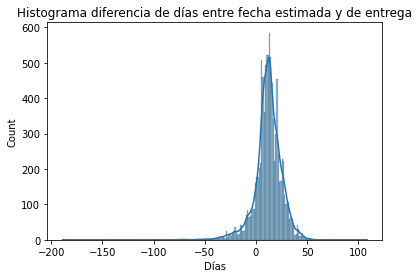

In [21]:
plt.title('Histograma diferencia de días entre fecha estimada y de entrega')
plt.xlabel('Días')
sns.histplot(data=(df3.time_promise-df3.time_wait).apply(lambda x:x.total_seconds()/(3600*24)), kde=True)

<AxesSubplot:title={'center':'Histograma días transcurridos en la entrega'}, xlabel='Días', ylabel='Count'>

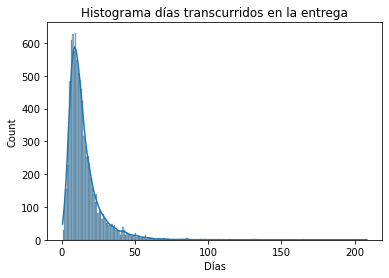

In [22]:
plt.title('Histograma días transcurridos en la entrega')
plt.xlabel('Días')
sns.histplot(data=df3.time, kde=True)

Como se puede observar en el anterior histograma los diás transcurridos para la entrega pueden ser bastante grandes. Pero en su mayoría son entre 1 y 20 días.

In [25]:
# variable volumen para eliminar las variables de dimensiones, el volumen será medido en centimetros cúbicos.
df3['volume'] = df3.product_length_cm * df3.product_height_cm * df3.product_width_cm

In [26]:
# se extraen las columnas con las cuales se va a desarrollar el estudio: clasificación, regresión y clustering
columns = ['customer_city', 'price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 
           'product_width_cm', 'geolocation_lat_cust', 'geolocation_lng_cust', 'geolocation_lat_sell',
           'geolocation_lng_sell', 'distance', 'volume', 'time']
df = df3[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9566 entries, 0 to 9565
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_city         9566 non-null   object 
 1   price                 9566 non-null   float64
 2   freight_value         9566 non-null   float64
 3   product_weight_g      9566 non-null   float64
 4   product_length_cm     9566 non-null   float64
 5   product_height_cm     9566 non-null   float64
 6   product_width_cm      9566 non-null   float64
 7   geolocation_lat_cust  9566 non-null   float64
 8   geolocation_lng_cust  9566 non-null   float64
 9   geolocation_lat_sell  9566 non-null   float64
 10  geolocation_lng_sell  9566 non-null   float64
 11  distance              9566 non-null   float64
 12  volume                9566 non-null   float64
 13  time                  9566 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


Primero se visualiza la correlación entre las variables. Se nota que hay una gran correlación entre las variables inciales y que motivo a hacer una regresión lineal para encontrar el valor del flete. Pero las variables de geolocalización como se esperaba no tienen gran incidencia con las demás, por tanto se eliminan y se consideran sólo para la clusterización.

<AxesSubplot:>

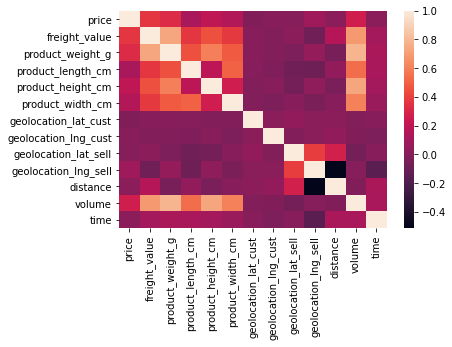

In [51]:
sns.heatmap(df.corr())

In [52]:
columns = ['customer_city', 'price', 'product_weight_g', 'distance', 'volume', 'freight_value', 'time']
df = df3[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9566 entries, 0 to 9565
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_city     9566 non-null   object 
 1   price             9566 non-null   float64
 2   product_weight_g  9566 non-null   float64
 3   distance          9566 non-null   float64
 4   volume            9566 non-null   float64
 5   freight_value     9566 non-null   float64
 6   time              9566 non-null   float64
dtypes: float64(6), object(1)
memory usage: 597.9+ KB


<AxesSubplot:>

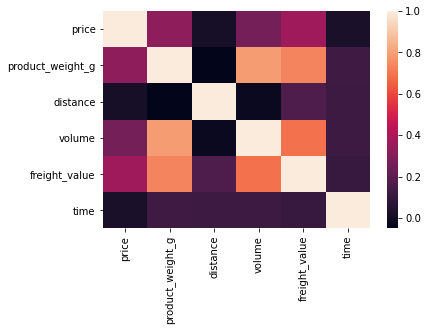

In [53]:
sns.heatmap(df.corr())

In [54]:
df.corr()

price  product_weight_g  distance    volume  \
price             1.000000          0.324754  0.014657  0.266004   
product_weight_g  0.324754          1.000000 -0.049725  0.786935   
distance          0.014657         -0.049725  1.000000 -0.018198   
volume            0.266004          0.786935 -0.018198  1.000000   
freight_value     0.367015          0.730716  0.164056  0.685964   
time              0.023706          0.124184  0.120429  0.117769   

                  freight_value      time  
price                  0.367015  0.023706  
product_weight_g       0.730716  0.124184  
distance               0.164056  0.120429  
volume                 0.685964  0.117769  
freight_value          1.000000  0.103712  
time                   0.103712  1.000000

Analizando si hay alguna relación entre tiempo transcurrido para la entrega y la distancia por ciudad, pero no se encuentra una diferencia notoría en los valores. Como también se observa en la correlación es un valor muy bajo.

<AxesSubplot:xlabel='distance', ylabel='time'>

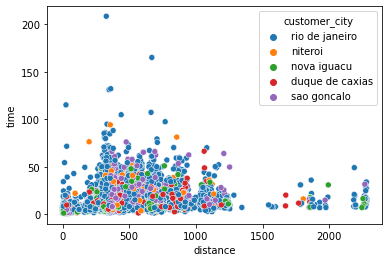

In [32]:
#df3.time_wait.apply(total_seconds())
sns.scatterplot(x='distance', y='time', data=df3, hue='customer_city')

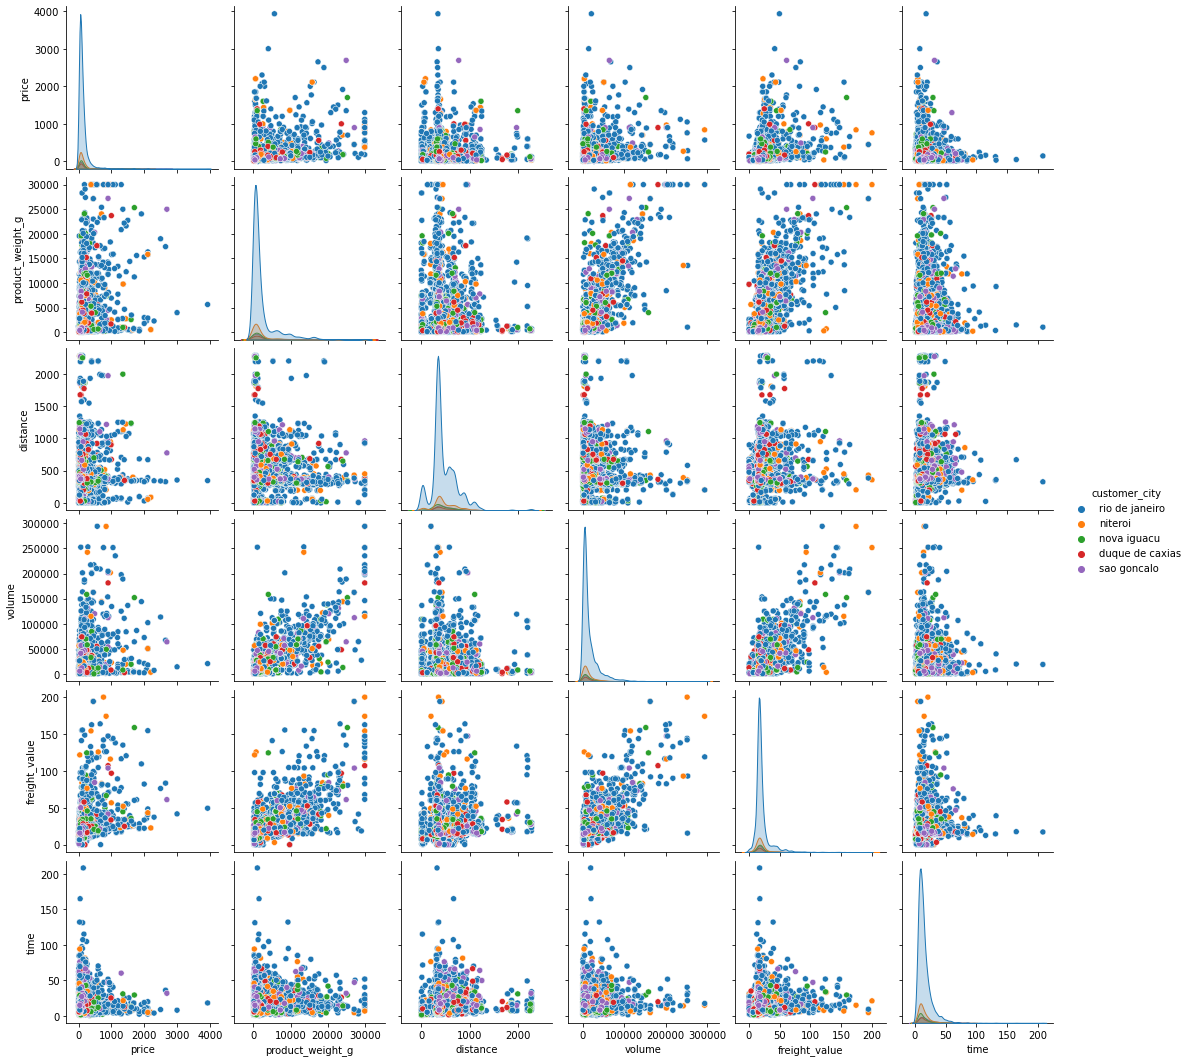

In [ ]:
sns.pairplot(df, hue='customer_city')

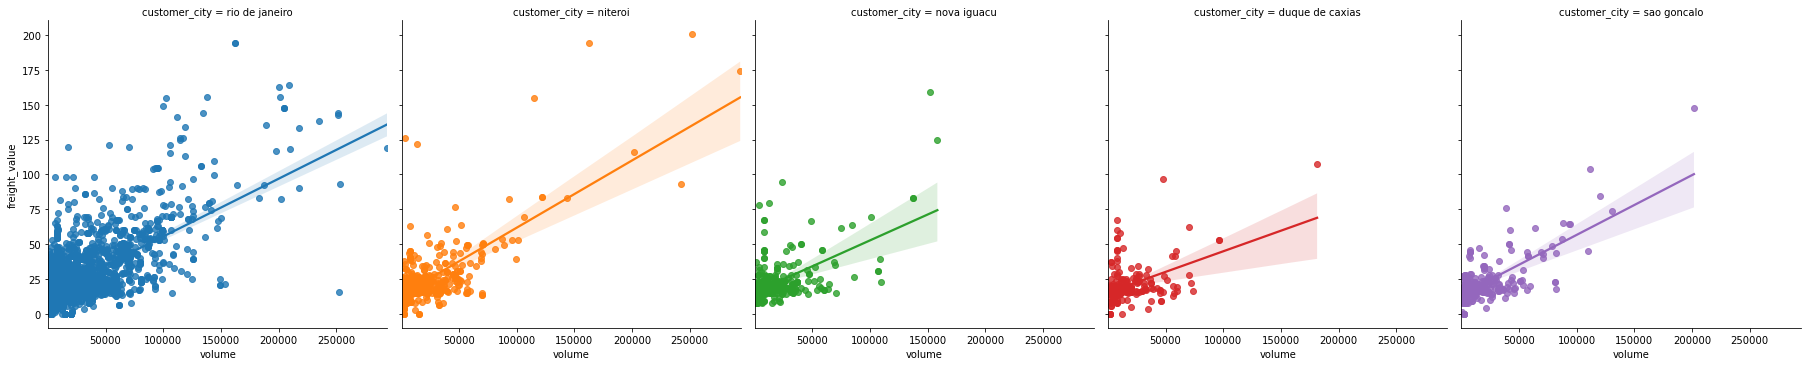

In [34]:
sns.lmplot(x='volume', y='freight_value', data=df, col='customer_city', hue='customer_city')

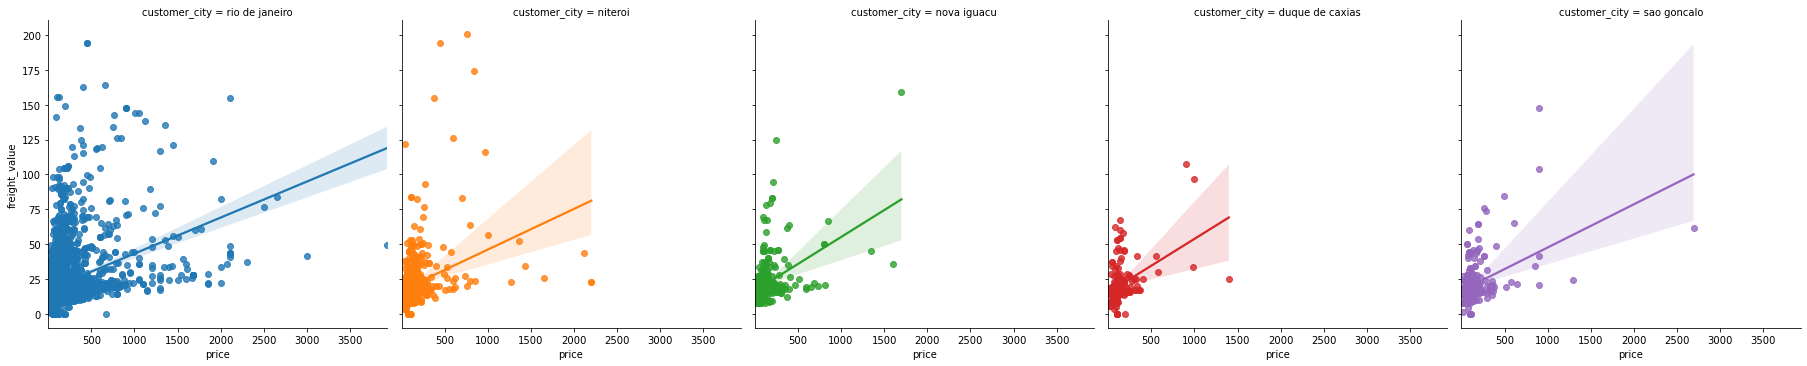

In [35]:
sns.lmplot(x='price', y='freight_value', data=df, col='customer_city', hue='customer_city')

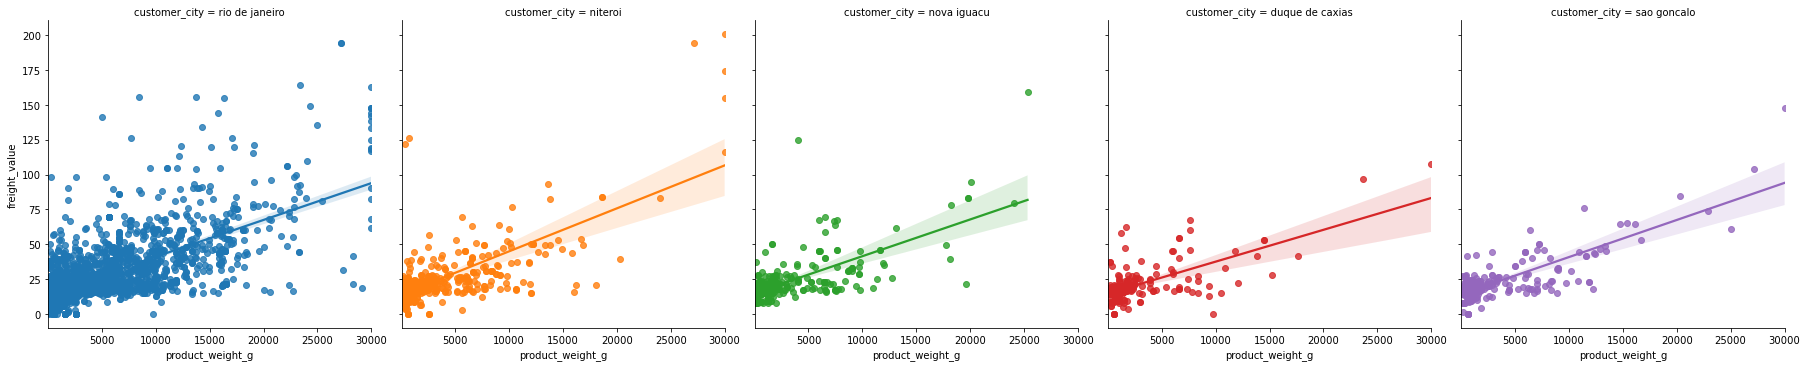

In [36]:
sns.lmplot(x='product_weight_g', y='freight_value', data=df, col='customer_city', hue='customer_city')

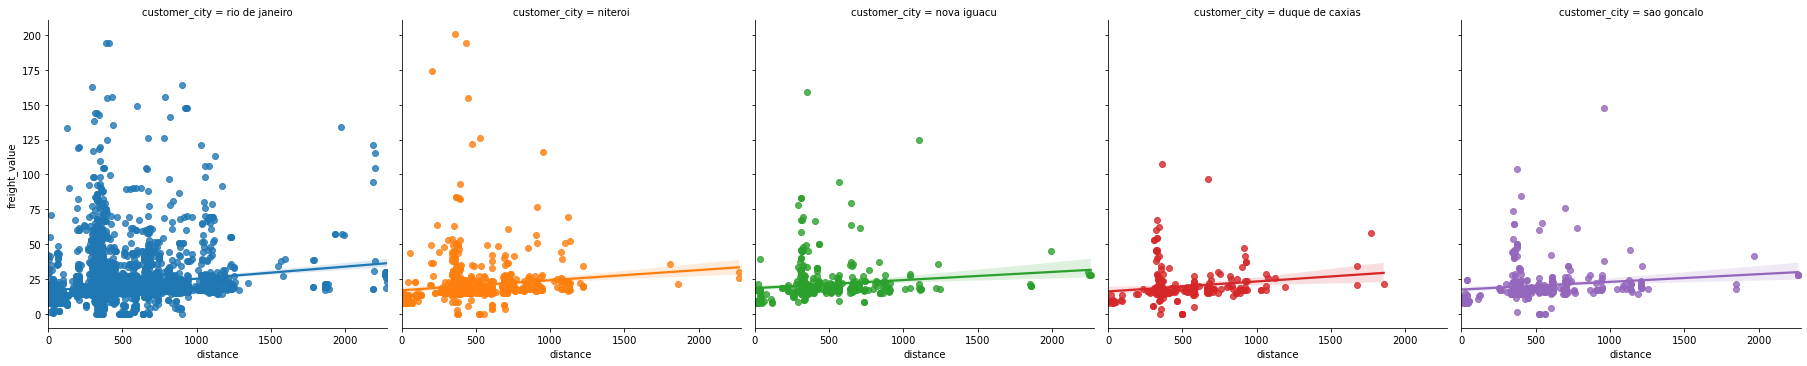

In [37]:
sns.lmplot(x='distance', y='freight_value', data=df, col='customer_city', hue='customer_city')

Como se pudo observar en las gráficas anteriores las variables de volumen, peso y precio tienen una fuerte correlación con el valor del frete. Lástimosamente la de distancia no tanto así pero se explorará en la regresión si realmente tiene efecto o no.

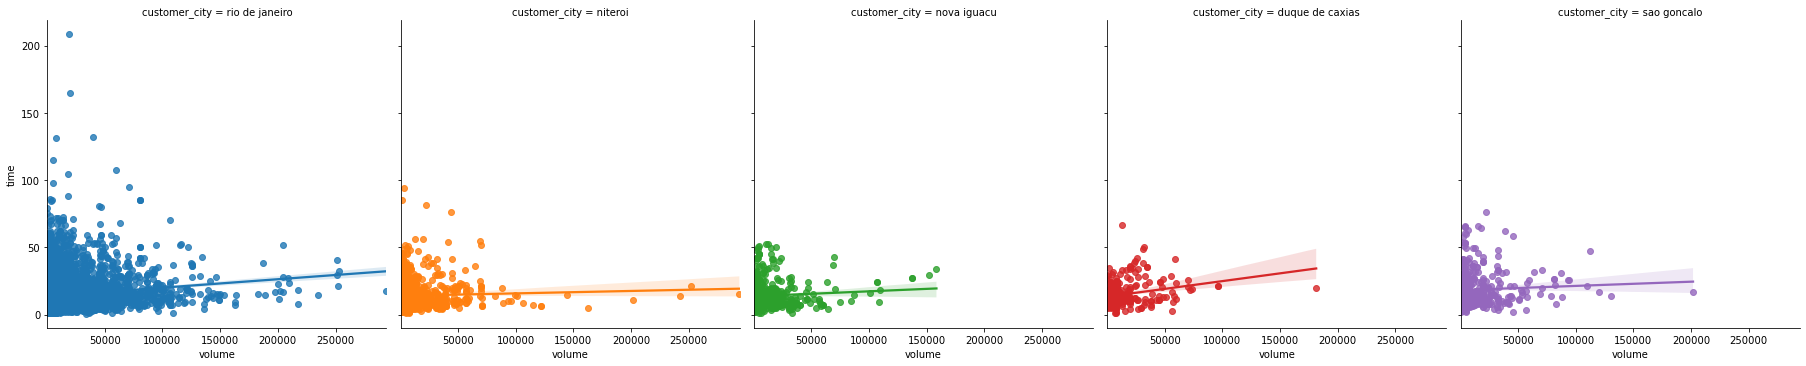

In [38]:
sns.lmplot(x='volume', y='time', data=df, col='customer_city', hue='customer_city')

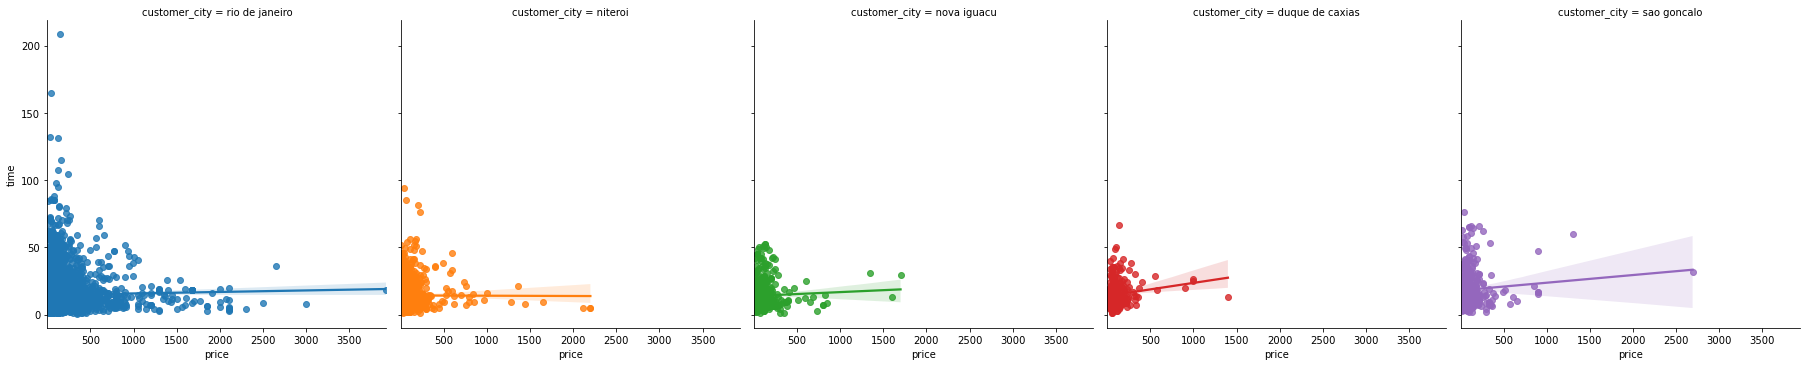

In [39]:
sns.lmplot(x='price', y='time', data=df, col='customer_city', hue='customer_city')

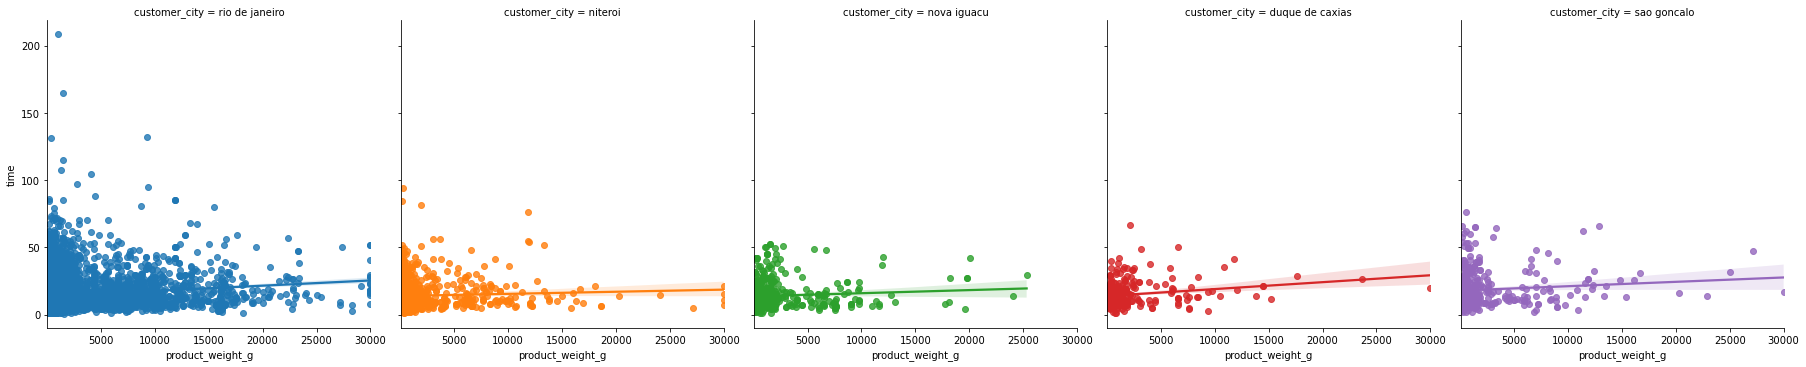

In [40]:
sns.lmplot(x='product_weight_g', y='time', data=df, col='customer_city', hue='customer_city')

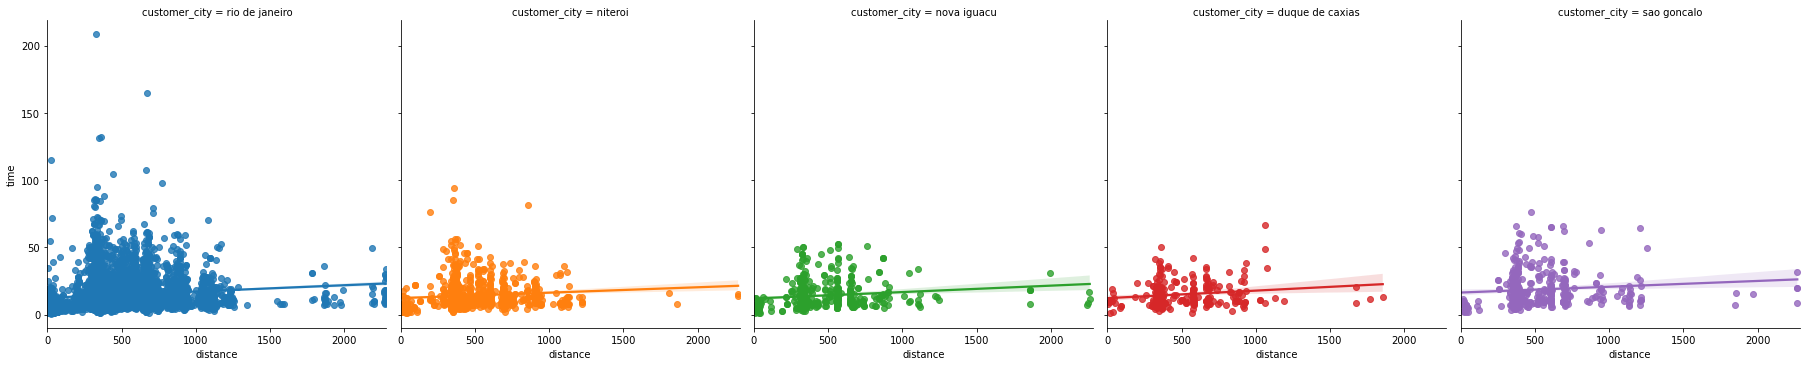

In [41]:
sns.lmplot(x='distance', y='time', data=df, col='customer_city', hue='customer_city')

Como se observa el tiempo no es una buena variable para ser estudiada como resultado de una regresión y por eso se desecha del estudio. 

Ahora se genera el DataFrame ```X``` el cuál contendrá las variables continuas usadas en cada estudio, como variables de año, mes y día de la semana, que serán usadas para la clasificación.

In [643]:
columns_con = ['price', 'product_weight_g', 'geolocation_lat_sell', 'geolocation_lng_sell',
               'geolocation_lat_cust', 'geolocation_lng_cust', 'distance', 'volume']
columns_cat = ['customer_city', 'product_category_name', 'seller_city', 'seller_state']
X = df3[columns_con + ['order_purchase_timestamp']].copy()
X['year'] = X.order_purchase_timestamp.dt.year
X['month'] = X.order_purchase_timestamp.dt.month
X['day'] = X.order_purchase_timestamp.dt.day_of_week
X.drop(columns='order_purchase_timestamp', inplace=True)
y_freight = df3['freight_value']

In [649]:
X.head()

price  product_weight_g  geolocation_lat_sell  geolocation_lng_sell  \
0  129.90            2950.0            -23.002860            -46.824206   
1   54.90            1750.0            -23.607473            -46.611699   
2  146.99           13175.0            -23.486111            -46.366721   
3  189.99           22800.0            -23.486111            -46.366721   
4  179.99           30000.0            -23.486111            -46.366721   

   geolocation_lat_cust  geolocation_lng_cust    distance    volume  year  \
0            -22.912592            -43.186293  372.602468    8100.0  2018   
1            -22.912592            -43.186293  358.347937    2240.0  2018   
2            -22.912592            -43.186293  331.239801   68970.0  2018   
3            -22.912592            -43.186293  331.239801  120960.0  2017   
4            -22.912592            -43.186293  331.239801  120960.0  2017   

   month  day  
0      2    2  
1      8    1  
2      3    2  
3     11    0  
4     11    0

In [650]:
# para clasificación se dirá si el envío se demoró más de lo prometido
y_clas = (df3.time_wait > df3.time_promise).astype(int)

In [651]:
# separando data en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y_clas, test_size=0.3, random_state=42)

### Análisis PCA

In [652]:
# definiendo función para estandarizar X_train
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [656]:
# generando DataFrame de vectores de componentes principales
pca_loadings = pd.DataFrame(PCA().fit(scaler.transform(X_train)).components_.T, index=X.columns, columns = ['V'+str(i) for i in range(1,12)])
pca_loadings

V1        V2        V3        V4        V5  \
price                 0.374773  0.038222 -0.024658  0.133644 -0.013722   
product_weight_g      0.646055  0.125325  0.040459  0.024387  0.001123   
geolocation_lat_sell -0.030909 -0.094703 -0.299876  0.768710 -0.170253   
geolocation_lng_sell  0.126831 -0.333546 -0.674486  0.109310 -0.019382   
geolocation_lat_cust -0.011681 -0.013919 -0.011429  0.121381  0.494172   
geolocation_lng_cust -0.012525  0.047484 -0.011791  0.121842  0.687578   
distance             -0.118318  0.297208  0.468232  0.579835 -0.078209   
volume                0.630995  0.119884  0.099700  0.008920 -0.002442   
year                 -0.091631  0.608559 -0.342771 -0.047573 -0.027580   
month                 0.064631 -0.622184  0.320723  0.076401  0.013273   
day                  -0.009871 -0.001218  0.055607 -0.068662 -0.496408   

                            V6        V7        V8        V9       V10  \
price                 0.053444 -0.249402  0.874528  0.009716 -0.040505   
product_weight_g      0.001487  0.074914 -0.217015 -0.033420 -0.355958   
geolocation_lat_sell -0.025205  0.045504 -0.143557  0.022175 -0.433184   
geolocation_lng_sell  0.011789 -0.050716 -0.035544  0.014890  0.561978   
geolocation_lat_cust  0.669401  0.529939  0.104912 -0.014604  0.019338   
geolocation_lng_cust  0.043096 -0.680214 -0.205835  0.013126 -0.048844   
distance             -0.039214 -0.010826  0.013612  0.004098  0.494112   
volume               -0.015163  0.074865 -0.296749 -0.002774  0.348008   
year                  0.018252 -0.002925  0.013400 -0.706554  0.012781   
month                -0.015832 -0.036521 -0.004403 -0.705851  0.001906   
day                   0.737605 -0.420657 -0.156253  0.014863 -0.001681   

                           V11  
price                 0.088519  
product_weight_g     -0.619791  
geolocation_lat_sell  0.262290  
geolocation_lng_sell -0.292216  
geolocation_lat_cust  0.008541  
geolocation_lng_cust  0.019118  
distance             -0.300164  
volume                0.602027  
year                  0.028998  
month                -0.000417  
day                  -0.004708

In [432]:
pca = PCA()
columns = ['PC'+str(i) for i in range(1,12)]
df_plot = pd.DataFrame(pca.fit_transform(scaler.transform(X_train)), index=X_train.index, columns=columns)
df_plot.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
2579  1.572182 -0.606083  0.337841 -0.130801  0.706176 -0.805437  0.261274   
9140 -0.920483 -0.983250  0.752143  0.576151 -0.527460 -0.108397  1.293296   
1867  0.101224 -2.075408 -1.338223 -0.860178 -1.226518 -1.272257 -0.005651   
1454 -0.792267  1.087469 -1.506594 -0.806160 -0.320534 -0.498753 -0.836406   
3914  4.188427  1.597220 -2.835104  5.050326 -0.748842 -0.754376 -0.853582   

           PC8       PC9      PC10      PC11  
2579 -0.941723  0.469336 -0.129316 -0.082045  
9140  0.186848  0.306055 -0.399011  0.124683  
1867  0.252848  0.338350  0.086403 -0.313015  
1454 -0.067389  0.467194 -0.001894  0.024960  
3914  0.068681  0.506242  1.383627 -1.000280

(0.0, 1.05)

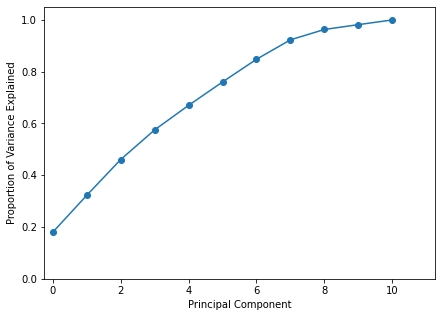

In [433]:
plt.figure(figsize=(7,5))
plt.plot( np.cumsum(pca.explained_variance_ratio_), '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(-0.25,11.25)
plt.ylim(0,1.05)

In [654]:
np.cumsum(pca.explained_variance_ratio_)

array([0.17959416, 0.32210998, 0.46053738, 0.57511327, 0.66997245,
       0.76037309, 0.84808952, 0.92318978, 0.96317845, 0.9818357 ,
       1.        ])

Se necesitan las primeras 8 componentes principales para explicar el 90% de la varianza, pero se nota en la siguiente gráfica que con la primera ya se encuentra una buena relación lineal entre la primera componente y el valor del frete.

<AxesSubplot:xlabel='PC1', ylabel='freight_value'>

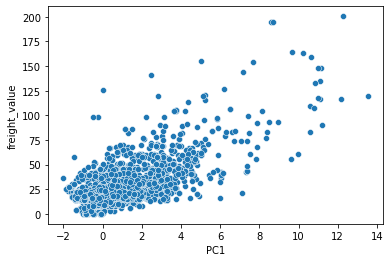

In [434]:
sns.scatterplot(x='PC1', y='freight_value', data=pd.concat([df_plot, y_freight.loc[X_train.index]], axis=1))

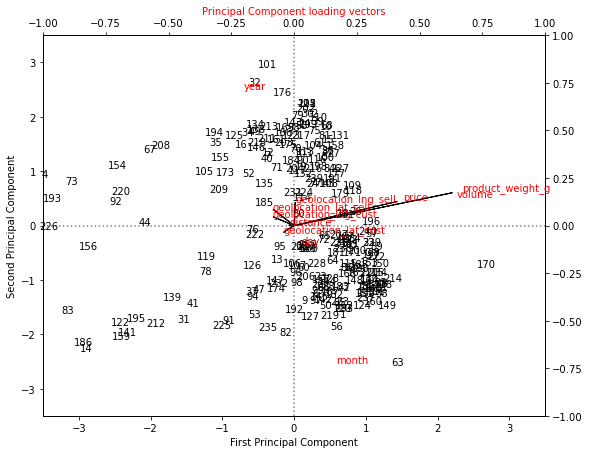

In [221]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in range(int(len(df_plot.index)/10)):
    ax1.annotate(i, (-df_plot.PC1.iloc[i], -df_plot.PC2.iloc[i]), ha='center')
    
# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.set_xlabel('Principal Component loading vectors', color='red')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (pca_loadings.V1.loc[i]*a, pca_loadings.V2.loc[i]*a), color='red')

# Plot vectors
for i in range(7):
    ax2.arrow(0,0,pca_loadings.V1[i], pca_loadings.V2[i])
#ax2.arrow(0,0,-pca_loadings.V1[1], -pca_loadings.V2[1])
#ax2.arrow(0,0,-pca_loadings.V1[2], -pca_loadings.V2[2])
#ax2.arrow(0,0,-pca_loadings.V1[3], -pca_loadings.V2[3])

Se ve que la mayor variación dentro de las variables escogidas y las dos primeras componentes son justamente el año, mes, peso y volumend el producto.

In [657]:
df_plot['delay'] = y_clas.loc[X_train.index]
df_plot

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
2579  1.572182 -0.606083  0.337841 -0.130801  0.706176 -0.805437  0.261274   
9140 -0.920483 -0.983250  0.752143  0.576151 -0.527460 -0.108397  1.293296   
1867  0.101224 -2.075408 -1.338223 -0.860178 -1.226518 -1.272257 -0.005651   
1454 -0.792267  1.087469 -1.506594 -0.806160 -0.320534 -0.498753 -0.836406   
3914  4.188427  1.597220 -2.835104  5.050326 -0.748842 -0.754376 -0.853582   
...        ...       ...       ...       ...       ...       ...       ...   
5734 -0.559851 -0.907173  1.109271  0.560865  0.355403 -0.492542 -0.252498   
5191 -0.531355 -0.605437  0.008953 -0.116003  0.748273  0.254503  0.520118   
5390 -0.624377  0.689214 -0.541211 -0.073524  0.351115 -0.100639  0.119011   
860  -0.175198  1.252452 -0.920749 -0.750411 -0.018716 -0.973966 -0.570228   
7270 -0.558803  1.889775 -0.251156  0.163506 -0.347023 -0.609786 -0.849223   

           PC8       PC9      PC10      PC11  delay  
2579 -0.941723  0.469336 -0.129316 -0.082045      0  
9140  0.186848  0.306055 -0.399011  0.124683      0  
1867  0.252848  0.338350  0.086403 -0.313015      0  
1454 -0.067389  0.467194 -0.001894  0.024960      0  
3914  0.068681  0.506242  1.383627 -1.000280      0  
...        ...       ...       ...       ...    ...  
5734 -0.178427  0.108038 -0.370456  0.120996      0  
5191  0.000543  0.950436 -0.073494  0.055343      0  
5390  0.314180 -0.425651 -0.159389  0.149581      0  
860  -0.597429  0.224773  0.276930  0.357250      0  
7270 -0.486960  0.461309 -0.162734  0.520818      0  

[6696 rows x 12 columns]

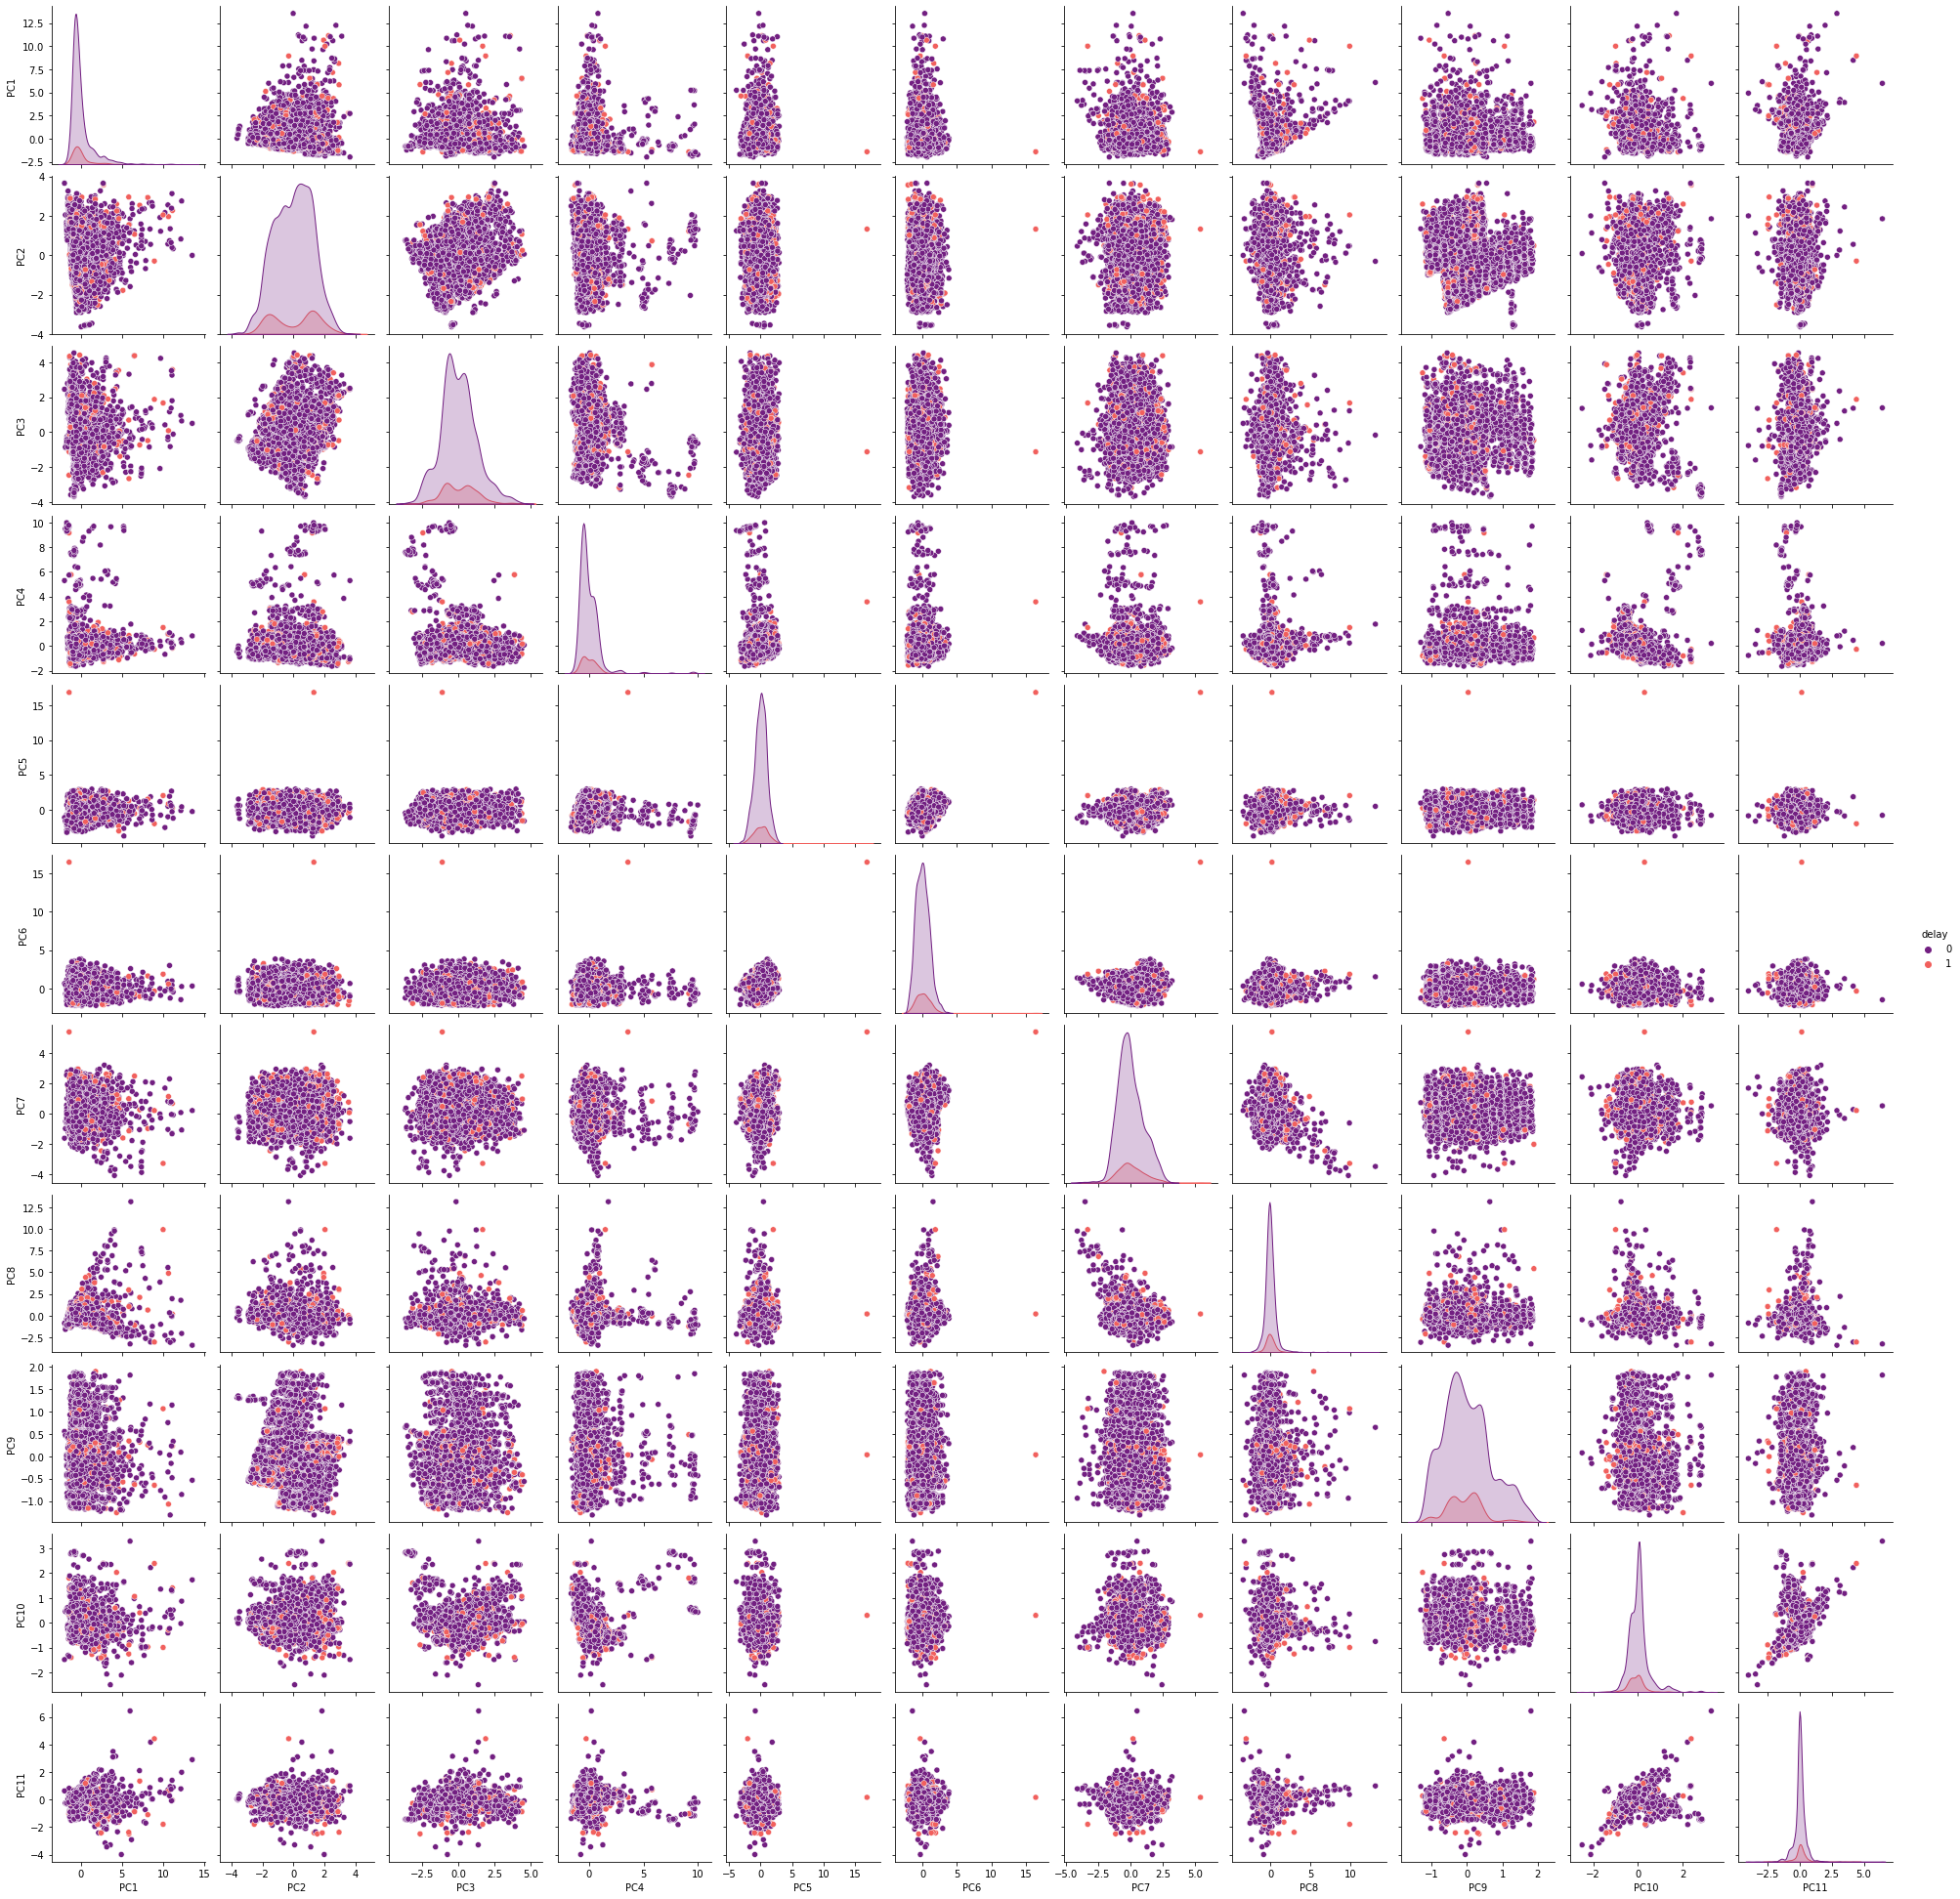

In [658]:
sns.pairplot(df_plot, hue='delay', palette="magma")

Como se puede observar en el anterior diagrama de dispersión de las componentes principales y los grupos determinados por si llega con retraso o no, las componentes principales no son suficientes para explicar este comportamiento. De hecho ninguna combinación bidimensional exhibe un comportamiento separatorio entre las clases. Esto es de esperarse, pues cómo se vió en el análisis hasta este punto se necesita de 8 componentes principales para explicar el 90% de la varianza.

### Clasificación

Una vez realizado el análisis descriptivo y ser observado que a priori las componentes principales no ayudan a resolver el problema de clasificación, se ejecutan los siguientes modelos:
- Regresión logística.
- Discriminante lineal.
- Discriminante cuadrático.
- Vecinos cercanos (KNN).
- Máquinas de vectores de soporte con kernel: lineal, rlbf y sigmoide.
- Baggin con árboles de decisión.
- Clasificador Random Forest.
- Clasificador XGBoost.

Los tres últimos **NO** harán uso de las componentes principales para su desarrollo.

In [648]:
print('La proporción de envíos que llegaron atrasados es: ', y_clas.sum()/len(y_clas))

La proporción de envíos que llegaron atrasados es:  0.12063558436127954


```y_clas``` será el valor respuesta para la clasificación, con la siguiente convención **1** si el envío demora más de lo prometido y **0** si no. Al analizar la proporción, se observa que es una gran minoría que no es entregado a tiempo.

Como se observa en la casilla anterior la proporción de registros en que el envío llega con delay o retraso es menor que los que llegan a tiempo. Por tal razón se hace una de técnica de sampling para suplir este desbalance, la técnica es Random Under Sampler que consiste en tomar una muestra aleatoria de la clase abundante y que sea igual a la clase no abundante, para efectos de este proyecto se usa el doble de registros.

In [659]:
#importando librería y ejecutando under sampler para equilibrar datos de muestra para envíos atrasados y a tiempo
from imblearn.under_sampling import RandomUnderSampler

X_train, y_train = RandomUnderSampler(sampling_strategy=0.5).fit_resample(X_train, y_train)

In [350]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para la regresión logística
logistic = LogisticRegression(max_iter=10000, tol=0.01, n_jobs=-1)
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic', logistic)])

param_grid = {
    'pca__n_components': list(range(1,9)),
    'logistic__C': np.logspace(-4, 4, 5),
    #'logistic__penalty': ['none', 'l2']
}

clf = RandomizedSearchCV(pipe, param_grid, random_state=0, scoring='roc_auc')
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('logistic',
                                              LogisticRegression(max_iter=10000,
                                                                 n_jobs=-1,
                                                                 tol=0.01))]),
                   param_distributions={'logistic__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                                        'pca__n_components': [1, 2, 3, 4, 5, 6,
                                                              7, 8]},
                   random_state=0, scoring='roc_auc')

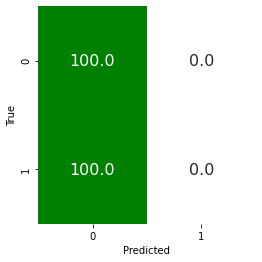

In [351]:
plotCM(y_test, clf.predict(X_test), normalize=True)

In [352]:
# diccionario de resultados: parámetros, score y score en test
models=dict()
models['LR'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

In [353]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para discriminante linear
lda = LDA()
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('lda', lda)])

param_grid = {
    'pca__n_components': list(range(1,12)),
}

clf = RandomizedSearchCV(pipe, param_grid, random_state=0, scoring='roc_auc')
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('lda',
                                              LinearDiscriminantAnalysis())]),
                   param_distributions={'pca__n_components': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10,
                                                              11]},
                   random_state=0, scoring='roc_auc')

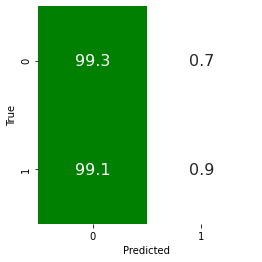

In [354]:
plotCM(y_test, clf.predict(X_test), normalize=True)

In [227]:
models['LDA'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

In [355]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para discriminante cuadrático
qda = QDA()
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('qda', qda)])

param_grid = {
    'pca__n_components': list(range(1,12)),
}

clf = RandomizedSearchCV(pipe, param_grid, random_state=0, scoring='roc_auc')
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('qda',
                                              QuadraticDiscriminantAnalysis())]),
                   param_distributions={'pca__n_components': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10,
                                                              11]},
                   random_state=0, scoring='roc_auc')

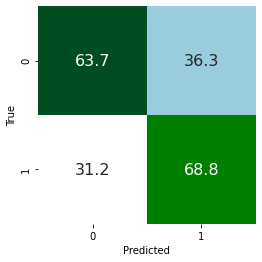

In [356]:
plotCM(y_test, clf.predict(X_test), normalize=True)

In [357]:
models['QDA'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

In [358]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para Naive Bayes
gnb = GaussianNB()
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('gnb', gnb)])

param_grid = {
    'pca__n_components': list(range(1,12)),
}

clf = RandomizedSearchCV(pipe, param_grid, random_state=0, scoring='roc_auc')
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('gnb', GaussianNB())]),
                   param_distributions={'pca__n_components': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10,
                                                              11]},
                   random_state=0, scoring='roc_auc')

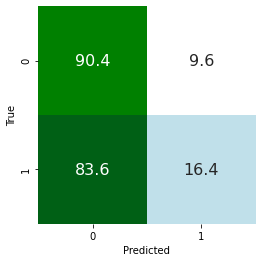

In [359]:
plotCM(y_test, clf.predict(X_test), normalize=True)

In [360]:
models['GNB'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

In [347]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para k-vecinos cercanos
knn = KNeighborsClassifier()
pipe = Pipeline(steps=[('scaler', scaler),('knn', knn)])
# ('pca', pca), 
param_grid = {
    #'pca__n_components': list(range(1,9)),
    'knn__n_neighbors': list(range(5,300,5)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1,2]
}

clf = RandomizedSearchCV(pipe, param_grid, random_state=0, n_iter=50, scoring='roc_auc')
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=50,
                   param_distributions={'knn__n_neighbors': [5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60, 65, 70, 75,
                                                             80, 85, 90, 95,
                                                             100, 105, 110, 115,
                                                             120, 125, 130, 135,
                                                             140, 145, 150, ...],
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=0, scoring='roc_auc')

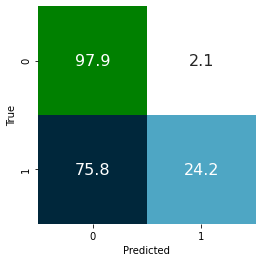

In [348]:
plotCM(y_test, clf.predict(X_test), normalize=True)

In [349]:
models['KNN'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

In [361]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para SVC kernel gaussiano
svc = SVC()
pipe = Pipeline(steps=[ ('svc', svc)])
#('pca', pca),
param_grid = {
    #'pca__n_components': list(range(1,9)),
    'svc__C': np.logspace(-2, 3, 6),
    'svc__gamma': np.logspace(-4, 1, 6)
}

clf = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, scoring='roc_auc')
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('svc', SVC())]), n_jobs=-1,
                   param_distributions={'svc__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'svc__gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
                   scoring='roc_auc')

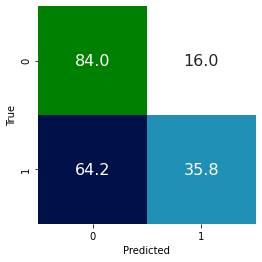

In [362]:
plotCM(y_test, clf.predict(X_test), normalize=True)

In [363]:
models['SVC_rbf'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

In [367]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para SVC (lineal)
svc = LinearSVC()
pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])

param_grid = {
    'pca__n_components': list(range(1,9)),
    'svc__C': np.logspace(-2, 3, 6)
}

clf = RandomizedSearchCV(pipe, param_grid, n_jobs=-1)
clf.fit(X_train, y_train)

/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning

RandomizedSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                             ('svc', LinearSVC())]),
                   n_jobs=-1,
                   param_distributions={'pca__n_components': [1, 2, 3, 4, 5, 6,
                                                              7, 8],
                                        'svc__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

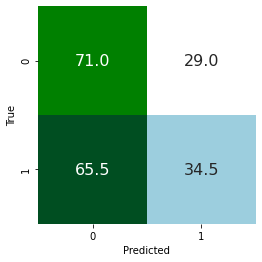

In [368]:
# Matriz de confusion sobre el test
plotCM(y_test, clf.predict(X_test), normalize=True)

In [369]:
models['SVC_linear'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

In [370]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para SVC kernel sigmoide
svc = SVC(kernel='sigmoid')
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)])

param_grid = {
    'pca__n_components': list(range(1,9)),
    'svc__C': np.logspace(-1, 2, 4),
    'svc__coef0': [i/10 for i in range(-5,5)],
    'svc__gamma': np.logspace(-2, 1, 4),
}

clf = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, scoring='roc_auc')

clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('svc', SVC(kernel='sigmoid'))]),
                   n_jobs=-1,
                   param_distributions={'pca__n_components': [1, 2, 3, 4, 5, 6,
                                                              7, 8],
                                        'svc__C': array([  0.1,   1. ,  10. , 100. ]),
                                        'svc__coef0': [-0.5, -0.4, -0.3, -0.2,
                                                       -0.1, 0.0, 0.1, 0.2, 0.3,
                                                       0.4],
                                        'svc__gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
                   scoring='roc_auc')

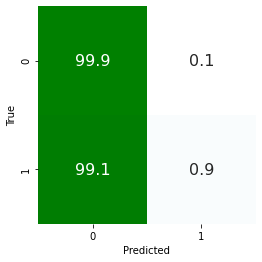

In [371]:
# Matriz de confusion sobre el test
plotCM(y_test, clf.predict(X_test), normalize=True)

In [372]:
models['SVC_sigmoid'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

In [373]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para Bagging Classifier con árboles de decisión
param_grid = {
    'max_samples': [0.5, 0.75, 1],
    'max_features': [0.5, 0.75, 1]
}

clf = GridSearchCV(BaggingClassifier(random_state = 0), param_grid, n_jobs=-1, scoring='roc_auc')

clf.fit(X_train, y_train)

models['Bagging'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

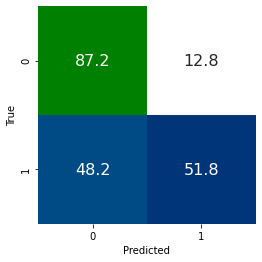

In [374]:
# Matriz de confusion sobre el test
plotCM(y_test, clf.predict(X_test), normalize=True)

In [375]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para Random Forest
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': [0.5, 0.75, 1]
}

clf = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, n_jobs=-1, scoring='roc_auc')

clf.fit(X_train, y_train)

models['RandomForest'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

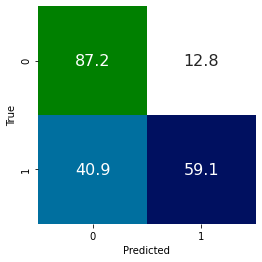

In [376]:
# Matriz de confusion sobre el test
plotCM(y_test, clf.predict(X_test), normalize=True)

In [377]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'gamma': np.logspace(-2, 1, 4),
    'learning_rate': np.logspace(-3, 0, 4)
}

clf = GridSearchCV(XGBClassifier(random_state = 0, use_label_encoder=False), param_grid, n_jobs=-1, scoring='roc_auc')

clf.fit(X_train, y_train)

models['XGBoost'] = (clf.best_params_, clf.best_score_, clf.score(X_test,y_test) )

[19:34:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


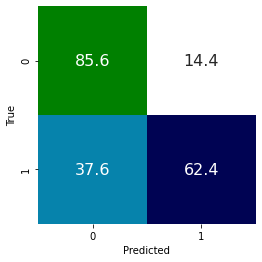

In [378]:
# Matriz de confusion sobre el test
plotCM(y_test, clf.predict(X_test), normalize=True)

Como se observó hasta este punto cada modelo generó una matriz de confusión con valores poco alentadores. De hecho se notó que en el mejor de los casos (Clasificador XGBoost) el éxito de predecir si iba a llegar atrasado es del 62.4%.

En el DataFrame se ilustra un resumen de los resultados obtenidos en los modelos de clasificación. Se puede notar que los tres mejores modelos son aquellos que no hacen uso de las componentes principales, sino de los datos originales, pero se basan en árboles de decisión, se escoge el mejor modelo basado en el área bajo la curva, dado que el accuracy fue una medida que no servía por la alta diferencia entre datos que llegan atrasados y los que no.

In [379]:
pd.DataFrame.from_dict(models, orient='index', columns=['parametros', 'train', 'test']).sort_values(by=['train', 'test'], ascending=False)

parametros     train  \
RandomForest  {'criterion': 'entropy', 'max_features': 'auto...  0.825554   
XGBoost       {'gamma': 0.01, 'learning_rate': 0.1, 'n_estim...  0.811786   
Bagging             {'max_features': 0.75, 'max_samples': 0.75}  0.793546   
QDA                                   {'pca__n_components': 10}  0.703978   
SVC_sigmoid   {'svc__gamma': 0.01, 'svc__coef0': -0.3, 'svc_...  0.655737   
GNB                                   {'pca__n_components': 10}  0.653063   
SVC_rbf                {'svc__gamma': 0.0001, 'svc__C': 1000.0}  0.601448   
SVC_linear           {'svc__C': 1000.0, 'pca__n_components': 8}  0.572823   
LR                 {'pca__n_components': 3, 'logistic__C': 1.0}  0.535247   

                  test  
RandomForest  0.831290  
XGBoost       0.818138  
Bagging       0.799597  
QDA           0.692948  
SVC_sigmoid   0.672919  
GNB           0.649412  
SVC_rbf       0.634189  
SVC_linear    0.668293  
LR            0.557886

### Exportación y Bootstrap mejor modelo de clasificación

Se ejecuta el bootstrap para estimar un intervalo de confianza con 95% de precisión del área bajo la curva ROC del mejor modelo de clasifiación. Además se hace la exportación del modelo para que pueda ser usado en producción.

In [380]:
models['RandomForest']

({'criterion': 'entropy',
  'max_features': 'auto',
  'max_samples': 0.75,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.8255539916175619,
 0.8312896683369124)

In [660]:
# implementación del mejor modelo
rf = RandomForestClassifier(max_samples=0.75, n_estimators=200, random_state=0, criterion='entropy')
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_samples=0.75, n_estimators=200,
                       random_state=0)

In [666]:
# importando libra para exportación de modelo
import joblib

# exportando modelo en archivo comprimido
joblib.dump(rf, "rf_clasificación.joblib", compress=3)

['rf_clasificación.joblib']

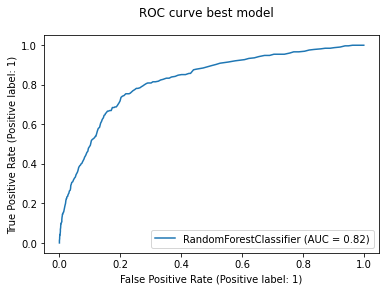

In [661]:
# gráfica de la curva ROC para el mejor modelo en el test set
best_model = plot_roc_curve(rf, X_test, y_test)
best_model.figure_.suptitle("ROC curve best model")

plt.show()

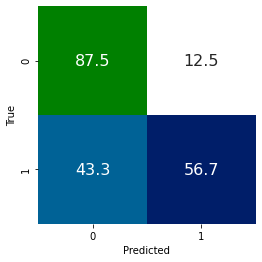

In [662]:
# Matriz de confusion sobre el test
plotCM(y_test, rf.predict(X_test), normalize=True)

In [663]:
best_features = pd.Series(rf.feature_importances_, index=X_train.columns)
best_features.sort_values(ascending=False)

month                   0.163120
distance                0.109807
geolocation_lng_cust    0.106935
geolocation_lat_cust    0.099758
volume                  0.093602
price                   0.092744
product_weight_g        0.090130
geolocation_lng_sell    0.085725
geolocation_lat_sell    0.083237
day                     0.050932
year                    0.024010
dtype: float64

Es de notar que las principales variables usadas para este clasificador son el mes, la distancia e increiblemente la geolocalización del comprador por encima de las de volumen, precio y peso del producto.

Se hace Bootstrap para estimar un intervalo de confianza para el área bajo la curva ROC del modelo:

In [452]:
# inicialando variables para ejecutar bootstrap usando random.choice
indices = list(range(X_train.shape[0]))
cantidad = int(np.floor(X_train.shape[0])/2)

arr = []

for i in range(200):
    train_index, test_index = train_test_split(np.random.choice(indices, cantidad), test_size=0.3)
    rf.fit(X_train.loc[train_index, :], y_train.loc[train_index])
    arr.append(roc_auc_score(y_train.loc[test_index], rf.predict(X_train.loc[test_index, :])))

In [453]:
arr = pd.Series(arr)
print(f'El intervalo de confianza del área bajo la curva ROC del modelo es ({arr.quantile(0.025):.4f},{arr.quantile(0.975):.4f}) con media {arr.mean():.4f}')

El intervalo de confianza del área bajo la curva ROC del modelo es (0.7077,0.7981) con media 0.7515


### Regresión

Aquí la variable a observar será el precio del envío basado en la información. Primero se hará un estudio estadístico de la regresión lineal, para ver si con algunas variables se puede explicar el precio del frete. Una vez sintetizado este estudio, se usará la versión de regresión de los modelos usados en clasificación.

- Máquinas de vectores de soporte con kernel: rbf y sigmoide.
- Bagging con árboles de decisión.
- Regresor Random Forest.
- Regresor XGBoost.

**NO** se hará uso de las componentes principales para su desarrollo. Se usará como medidad de desempeño el $R^2$ y el RMSE para definir el mejor modelo. Este último estará medido en reales y dira en promedio que tanto se puede esperar pagar de más o menos por cada frete.

In [667]:
# separando data en train y test de nuevo, porque para clasificación se hizo under sample
X_train, X_test, y_train, y_test = train_test_split(X, y_freight, test_size=0.3, random_state=42)

In [668]:
# guardando indices para modelos futuros
indices_train = X_train.index
indices_test = X_test.index

In [670]:
# para estandarizar los train y test datasets
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [671]:
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index=X_test.index)

Se inicia con una regresión lineal, y se hará un gran énfasis en los valores estadísticos como residuos, y el $R^2$ para ir eliminando variables y escoger la mejor combinación.

In [272]:
from statsmodels.formula.api import ols

formula = 'freight_value ~ price + product_weight_g + geolocation_lat_sell + geolocation_lng_sell + geolocation_lat_cust + geolocation_lng_cust + distance + volume + year + month + day'

mod = ols(formula=formula, data=pd.concat([X_train, y_train], axis=1))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          freight_value   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1045.
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:35:05   Log-Likelihood:                -23915.
No. Observations:                6696   AIC:                         4.785e+04
Df Residuals:                    6684   BIC:                         4.794e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               20.7210 

Se eliminan las variables que tuvieron valores de p mayores a **0**.

In [273]:
formula = 'freight_value ~ price + product_weight_g + distance + volume + year + month'

mod = ols(formula=formula, data=pd.concat([X_train, y_train], axis=1))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          freight_value   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1914.
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:35:14   Log-Likelihood:                -23919.
No. Observations:                6696   AIC:                         4.785e+04
Df Residuals:                    6689   BIC:                         4.790e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           20.7210      0.105  

Se eliminan los que tienen estadístico de prueba más pequeño, a saber: ```year``` y ```month```

In [278]:
formula = 'freight_value ~ price + product_weight_g + distance + volume'

mod = ols(formula=formula, data=pd.concat([X_train, y_train], axis=1))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          freight_value   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2716.
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:38:53   Log-Likelihood:                -24036.
No. Observations:                6696   AIC:                         4.808e+04
Df Residuals:                    6691   BIC:                         4.812e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           20.7210      0.107  

Eliminando más variables **NO** se obtienen mejoría en el modelo, así que por tener mejor $R^2$ se usará el segundo con las variables que allí se despliegan. 

In [295]:
formula = 'freight_value ~ price + product_weight_g + distance + volume + year + month'

mod = ols(formula=formula, data=pd.concat([X_train, y_train], axis=1))
res = mod.fit()

from sklearn.metrics import mean_squared_error

print('El error cuadrático medio (RMSE) del modelo lineal es: ', mean_squared_error(y_test, res.predict(X_test), squared=False))

El error cuadrático medio (RMSE) del modelo lineal es:  8.390072863251161


Se hace un QQ-plot para observar el comportamiento de los residuales y así implementar una prueba y ajuste Box-Cox,

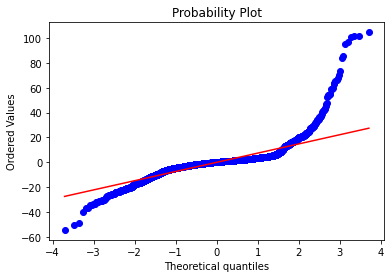

In [286]:
import pylab 
import scipy.stats as stats

stats.probplot(res.resid, dist="norm", plot=pylab)
pylab.show()

Se hace una transformación Box-Cox para eliminar esas colas pesadas en los residuos.

In [287]:
from scipy import stats

train_data,fitted_lambda = stats.boxcox(y_train+0.001)

In [288]:
train_data = pd.Series(train_data, index=y_train.index, name = 'freight_value')

In [293]:
formula = 'freight_value ~ price + product_weight_g + distance + volume'

mod = ols(formula=formula, data=pd.concat([X_train, train_data], axis=1))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          freight_value   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     1865.
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:46:07   Log-Likelihood:                -10062.
No. Observations:                6696   AIC:                         2.013e+04
Df Residuals:                    6691   BIC:                         2.017e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.2073      0.013  

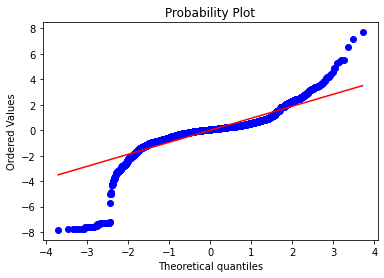

In [294]:
import pylab 
import scipy.stats as stats

stats.probplot(res.resid, dist="norm", plot=pylab)
pylab.show()

Como se puede observar después de ejecutarlo, no se obtiene ninguna mejoría, por tal razón se continuará con el modelo original, y ahora se harán pruebas con modelos no estadísticos, pero basados en las columnas del mejor modelo de regresión lineal.

In [297]:
# diccionario para guardar desempeño de cada modelo
regresion = dict()
regresion['lineal']=(None, res.rsquared, mean_squared_error(y_test, res.predict(X_test), squared=False))

In [672]:
# librería para ejecutar regresiones Ridge y Lasso
from sklearn import linear_model

In [300]:
# configuración de pipeline y parámetros, y ejecución de la regresión con regularización Ridge
pipe = Pipeline(steps=[('ridge', linear_model.Ridge())])

param_grid = {
    'ridge__alpha': np.logspace(-3, 3, 7)
}

reg = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='r2')

reg.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ridge', Ridge())]), n_jobs=-1,
             param_grid={'ridge__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='r2')

In [301]:
regresion['ridge'] = (reg.best_params_, reg.best_score_, mean_squared_error(y_test, reg.predict(X_test), squared=False))

In [302]:
# configuración de pipeline y parámetros, y ejecución de la regresión con regularización Lasso
pipe = Pipeline(steps=[('lasso', linear_model.Lasso())])

param_grid = {
    'lasso__alpha': np.logspace(-3, 3, 7)
}

reg = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='r2')

reg.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('lasso', Lasso())]), n_jobs=-1,
             param_grid={'lasso__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='r2')

In [303]:
regresion['lasso'] = (reg.best_params_, reg.best_score_, mean_squared_error(y_test, reg.predict(X_test), squared=False))

In [307]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para SVC kernel gaussiano
svr = SVR()
pipe = Pipeline(steps=[ ('svr', svr)])

param_grid = {
    'svr__C': np.logspace(-2, 3, 6),
    'svr__gamma': np.logspace(-4, 1, 6),
    #'svr_epsilon': np.logspace(-4, 1, 6)
}

reg = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, scoring='r2')
reg.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('svr', SVR())]), n_jobs=-1,
                   param_distributions={'svr__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'svr__gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
                   scoring='r2')

In [309]:
regresion['SVR_rbf'] = (reg.best_params_, reg.best_score_, mean_squared_error(y_test, reg.predict(X_test), squared=False))

In [314]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para SVC kernel gaussiano
svr = SVR(kernel = 'sigmoid')
pipe = Pipeline(steps=[ ('svr', svr)])

param_grid = {
    'svr__C': np.logspace(-2, 3, 6),
    'svr__gamma': np.logspace(-4, 1, 6),
    'svr__coef0': [i/10 for i in range(-5,5)]
}

reg = RandomizedSearchCV(pipe, param_grid, n_jobs=-1, scoring='r2')
reg.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('svr', SVR(kernel='sigmoid'))]),
                   n_jobs=-1,
                   param_distributions={'svr__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'svr__coef0': [-0.5, -0.4, -0.3, -0.2,
                                                       -0.1, 0.0, 0.1, 0.2, 0.3,
                                                       0.4],
                                        'svr__gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
                   scoring='r2')

In [316]:
regresion['SVR_sigmoid'] = (reg.best_params_, reg.best_score_, mean_squared_error(y_test, reg.predict(X_test), squared=False))

In [323]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para Bagging Classifier con árboles de decisión
param_grid = {
    'max_samples': [0.5, 0.75, 1],
    'max_features': [0.5, 0.75, 1]
}

reg = GridSearchCV(BaggingRegressor(random_state = 0), param_grid, n_jobs=-1, scoring='r2')

reg.fit(X_train, y_train)

GridSearchCV(estimator=BaggingRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.75, 1],
                         'max_samples': [0.5, 0.75, 1]},
             scoring='r2')

In [324]:
regresion['Bagging'] = (reg.best_params_, reg.best_score_, mean_squared_error(y_test, reg.predict(X_test), squared=False))

In [325]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': [0.5, 0.75, 1]
}

reg = RandomizedSearchCV(RandomForestRegressor(random_state = 0), param_grid, n_jobs=-1, scoring='r2')

reg.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': [0.5, 0.75, 1],
                                        'min_samples_split': [2, 10, 50, 100,
                                                              200],
                                        'n_estimators': [50, 100, 200]},
                   scoring='r2')

In [327]:
regresion['Random'] = (reg.best_params_, reg.best_score_, mean_squared_error(y_test, reg.predict(X_test), squared=False))

In [328]:
# configuración de pipeline y parámetros, y ejecución del Randomized Search para XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'gamma': np.logspace(-2, 1, 4),
    'learning_rate': np.logspace(-3, 0, 4)
}

reg = RandomizedSearchCV(XGBRegressor(random_state = 0), param_grid, n_jobs=-1, scoring='r2')

reg.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=0, reg_alpha=None,
                                          reg_lambda=None,
        

In [330]:
regresion['XGBoost'] = (reg.best_params_, reg.best_score_, mean_squared_error(y_test, reg.predict(X_test), squared=False))

In [331]:
pd.DataFrame.from_dict(regresion, orient='index', columns=['parametros', 'r2', 'RMSE_test']).sort_values(by=['r2', 'RMSE_test'], ascending=False)

parametros        r2  \
Random       {'n_estimators': 100, 'min_samples_split': 2, ...  0.760420   
Bagging            {'max_features': 0.75, 'max_samples': 0.75}  0.696256   
SVR_rbf                   {'svr__gamma': 0.1, 'svr__C': 100.0}  0.689629   
lineal                                                    None  0.631987   
XGBoost      {'n_estimators': 100, 'learning_rate': 1.0, 'g...  0.631959   
ridge                                  {'ridge__alpha': 100.0}  0.624186   
lasso                                   {'lasso__alpha': 0.01}  0.624078   
SVR_sigmoid  {'svr__gamma': 0.1, 'svr__coef0': -0.5, 'svr__...  0.373285   

             RMSE_test  
Random        6.567581  
Bagging       7.203468  
SVR_rbf       7.814128  
lineal        8.390073  
XGBoost       8.707253  
ridge         8.369132  
lasso         8.383638  
SVR_sigmoid  11.393189

### Exportación y Bootstrap mejor modelo de regresión

Se hace la exportación del modelo y el bootstrap para estimar un intervalo de confianza con 95% de precisión del RMSE del mejor modelo de regresión. Como ocurrió en la clasificación también el mejor modelo para hacer la regresión es un RandomForest. Los parámetros para este caso son:

In [333]:
regresion['Random'][0]

{'n_estimators': 100,
 'min_samples_split': 2,
 'max_samples': 0.75,
 'max_features': 'log2'}

In [673]:
# implementación del mejor modelo
rf = RandomForestRegressor(max_samples=0.75, n_estimators=100, random_state=0, max_features='log2')
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='log2', max_samples=0.75, random_state=0)

In [675]:
# exportando modelo en archivo comprimido
joblib.dump(scaler, 'reg_scaler.joblib', compress=3)
joblib.dump(rf, "rf_regresion.joblib", compress=3)

['rf_regresion.joblib']

In [676]:
pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

product_weight_g        0.331519
volume                  0.279523
price                   0.114644
distance                0.065552
geolocation_lng_sell    0.051123
geolocation_lat_sell    0.050115
geolocation_lat_cust    0.029125
geolocation_lng_cust    0.026269
month                   0.024419
day                     0.014703
year                    0.013008
dtype: float64

In [458]:
print('El RMSE del modelo en el conjunto test es: ', mean_squared_error(y_test, rf.predict(X_test), squared=False))

El RMSE del modelo en el conjunto test es:  6.490893578625206


Como se observó en el análisis del modelo de regresión lineal se encontraron que las mejores variables para hacer la predicción fueron ```product_weight_g```, ```volume```, ```price```, ```distance```. Analogamente sucede con el RandomForestRegressor, además de manera positiva se encuentra que el error cuadrático medio de la predicción es aproximadamente de 6.56 reales. Lo cual es un valor bajo.

In [459]:
# inicialando variables para ejecutar bootstrap usando random.choice
indices = np.array(indices_train)
cantidad = int(np.floor(X_train.shape[0]/2))

arr = []

for i in range(100):
    train_index, test_index = train_test_split(np.random.choice(indices, cantidad), test_size=0.3)
    rf.fit(X_train.loc[train_index, :], y_train.loc[train_index])
    arr.append(mean_squared_error(y_train.loc[test_index], rf.predict(X_train.loc[test_index, :]), squared=False))

In [460]:
arr = pd.Series(arr)
print(f'El intervalo de confianza del RMSE del modelo es ({arr.quantile(0.025):.4f},{arr.quantile(0.975):.4f}) con media {arr.mean():.4f}')

El intervalo de confianza del RMSE del modelo es (5.1370,8.0777) con media 6.5333


### Clustering

Como parte del problema se ejecutará una segmentación para la empresa de envíos, y que se tenga presente el volumen, el peso y la geolocalización del vendedor para hacer una organización adecuada, y así poder ejecutar medidas de mejoramiento en el centro de acopio y despacho.

Se ejecutarán los modelos de aprendizaje no supervisado:
- K-means
- K-medoids
- Clustering jerarquico

Se realizará un ciclo variando la cantidad de clusters / altura del árbol para identificar usando método del codo y silueta cuál es la mejor configuración.

In [595]:
# preparando los datos para hacer la clusterización

columnas_cluster = ['product_weight_g',  'volume', 'geolocation_lat_sell', 'geolocation_lng_sell']
data = X[columnas_cluster].copy()
data = pd.DataFrame(scaler.fit_transform(data), columns=columnas_cluster)

#### k-means

In [540]:
# leyendo libreria y ajustando ciclo, variables aleatorias para hacer la estimación del número apropiado de clusters
from sklearn.metrics import silhouette_samples, silhouette_score

score = []
silueta = []

# ciclo para ejecutar varias veces el modelo con diferentes tamaños de cluster
# Se hacen hasta 15 clusters debido a iteraciones en las cuales se evidenció usando la técnica del codo que no eran
# necesarias más de este valor
for n in range(2,30):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(data)
    score.append(-kmeans.score(data))
    silueta.append(silhouette_score(data, kmeans.labels_))

<AxesSubplot:>

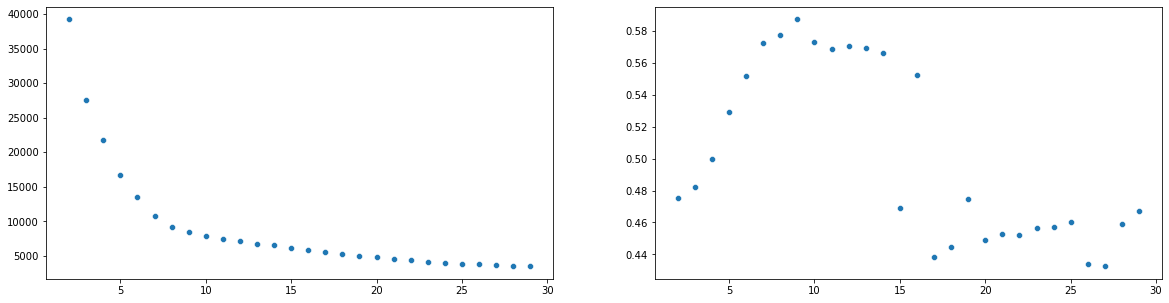

In [541]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.scatterplot(x=list(range(2,30)), y=score, ax=ax[0])
sns.scatterplot(x=list(range(2,30)), y=silueta, ax=ax[1])

Se recomienda usar 8 clusters. Puesto que es el valor aproximado por el método del codo y adicionalmente tienen el mayor valor usando el score de silueta.

In [597]:
kmeans = KMeans(n_clusters = 8, random_state=42).fit(data)
data['labels']=kmeans.labels_

<AxesSubplot:xlabel='product_weight_g', ylabel='volume'>

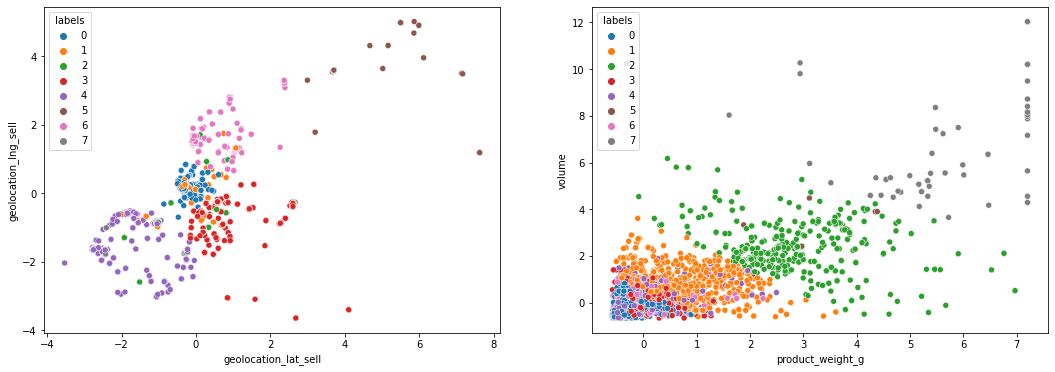

In [549]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
sns.scatterplot(x='geolocation_lat_sell', y='geolocation_lng_sell', data=data, hue='labels', palette="tab10", ax=ax[0])
sns.scatterplot(x='product_weight_g', y='volume', data=data, hue='labels', palette="tab10", ax=ax[1])

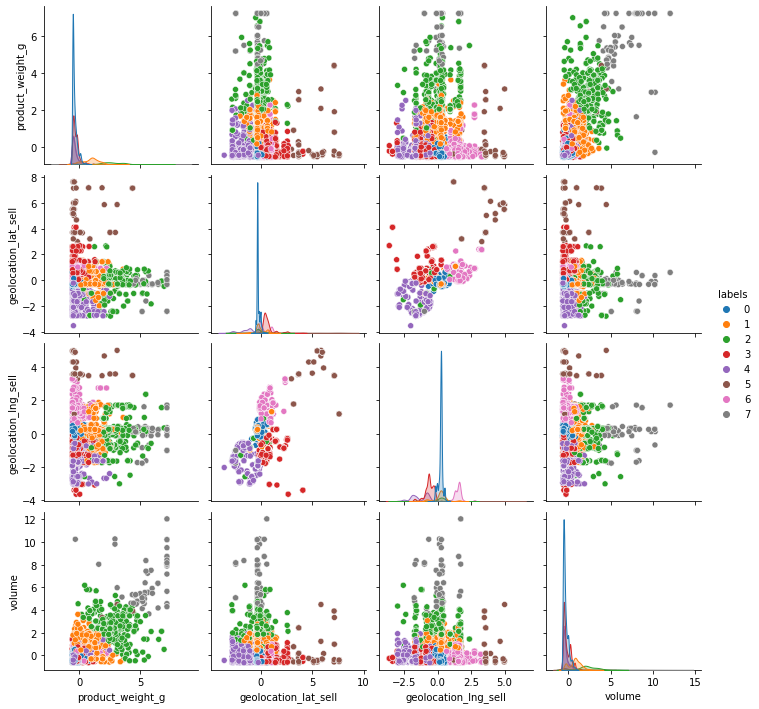

In [563]:
sns.pairplot(data.iloc[:,:5], hue='labels', palette="tab10")

#### k-medoids

In [574]:
# ajustando ciclo, variables auxiliares para hacer la estimación del número apropiado de clusters

score = []
silueta = []

# ciclo para ejecutar varias veces el modelo con diferentes tamaños de cluster
# Se hacen hasta 20 clusters debido a iteraciones en las cuales se evidenció usando la técnica del codo que no eran
# necesarias más de este valor
for n in range(3,20):
    kmedoids = KMedoids(n_clusters=n, random_state=42).fit(data.iloc[:,:4])
    score.append(kmedoids.inertia_)
    silueta.append(silhouette_score(data.iloc[:,:4], kmedoids.labels_))

/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/Users/jdrojasga/miniconda3/lib/python3.

<AxesSubplot:>

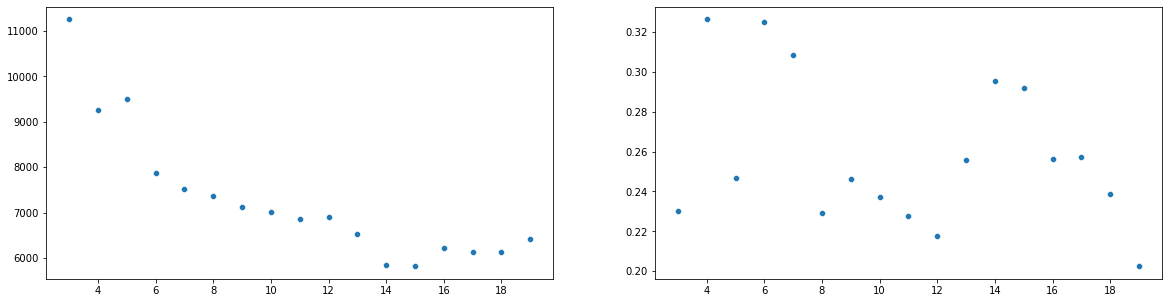

In [575]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.scatterplot(x=list(range(3,20)), y=score, ax=ax[0])
sns.scatterplot(x=list(range(3,20)), y=silueta, ax=ax[1])

Se recomienda usar 6 clusters. Puesto que es el valor aproximado por el método del codo y adicionalmente tienen el mayor valor usando el score de silueta.

In [678]:
kmedoids = KMedoids(n_clusters = 6, random_state=42).fit(data.iloc[:,:4])
data['labels2']=kmedoids.labels_

/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/Users/jdrojasga/miniconda3/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(


Como se muestra en la ejecución hay dos clusters que no poseen ningún valor.

<AxesSubplot:xlabel='product_weight_g', ylabel='volume'>

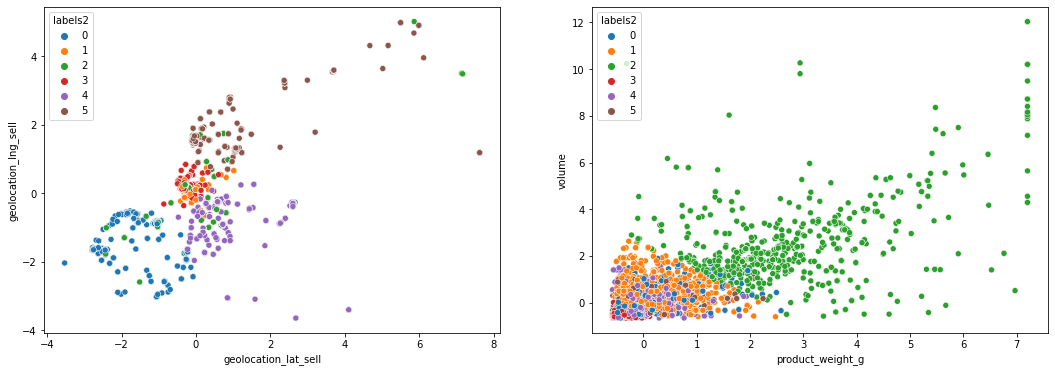

In [679]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
sns.scatterplot(x='geolocation_lat_sell', y='geolocation_lng_sell', data=data, hue='labels2', palette="tab10", ax=ax[0])
sns.scatterplot(x='product_weight_g', y='volume', data=data, hue='labels2', palette="tab10", ax=ax[1])

#### Clustering jerárquico 

In [580]:
# ajustando ciclo, variables aleatorias para hacer la estimación del número apropiado de clusters

silueta = []

# ciclo para ejecutar varias veces el modelo con diferentes tamaños de cluster
# Se hacen hasta 20 clusters debido a iteraciones en las cuales se evidenció usando la técnica del codo que no eran
# necesarias más de este valor
for n in range(2,20):
    jerarquico = AgglomerativeClustering(n_clusters=n).fit(data.iloc[:,:4])
    silueta.append(silhouette_score(data.iloc[:,:4], jerarquico.labels_))

<AxesSubplot:>

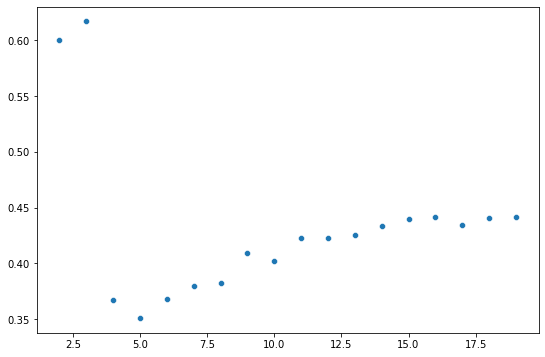

In [582]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
sns.scatterplot(x=list(range(2,20)), y=silueta, ax=ax)

Se escogen 3 clusters para la clusterización jerarquica. A continuación las gráficas que resumen el comportamiento de los datos.

In [680]:
jerarquico = AgglomerativeClustering(n_clusters = 3).fit(data.iloc[:,:4])
data['labels3']=jerarquico.labels_

<AxesSubplot:xlabel='product_weight_g', ylabel='volume'>

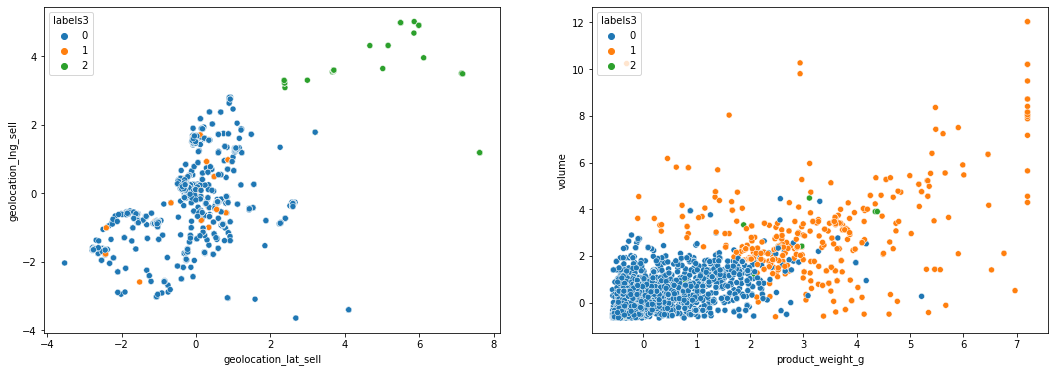

In [681]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
sns.scatterplot(x='geolocation_lat_sell', y='geolocation_lng_sell', data=data, hue='labels3', palette="tab10", ax=ax[0])
sns.scatterplot(x='product_weight_g', y='volume', data=data, hue='labels3', palette="tab10", ax=ax[1])

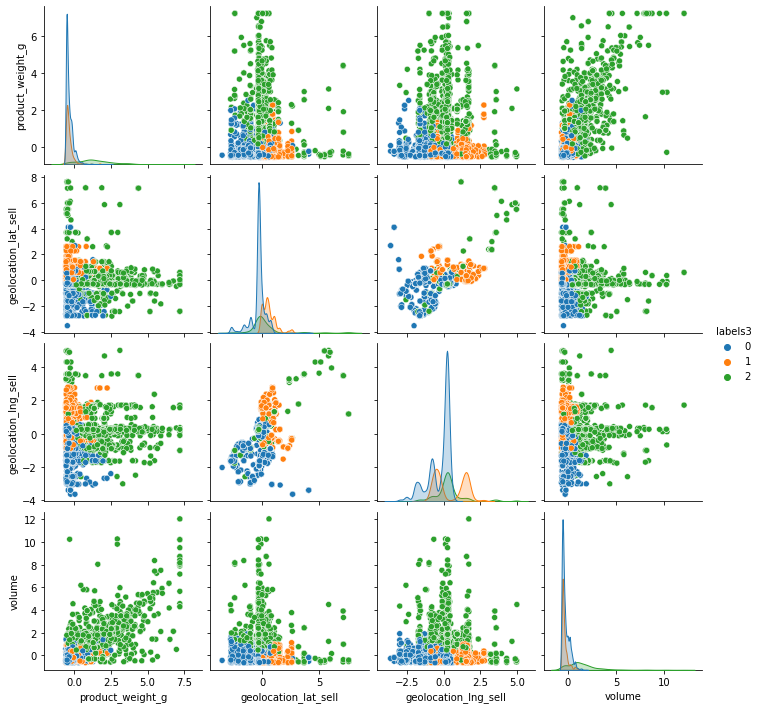

In [585]:
sns.pairplot(data.iloc[:,[0,1,2,3,6]], hue='labels3', palette="tab10")

#### Mejor clusterización: k-means

Se escogen los labels generados por k-means y con ellos se hace el análisis por grupos y se resaltan los aspectos importantes de cada uno. En principio los resultados muestran una buena separación por tamaños de los productos y algunos por geolocalización.

In [598]:
visualizar = X[columnas_cluster].copy()
visualizar['labels'] = data.labels.values

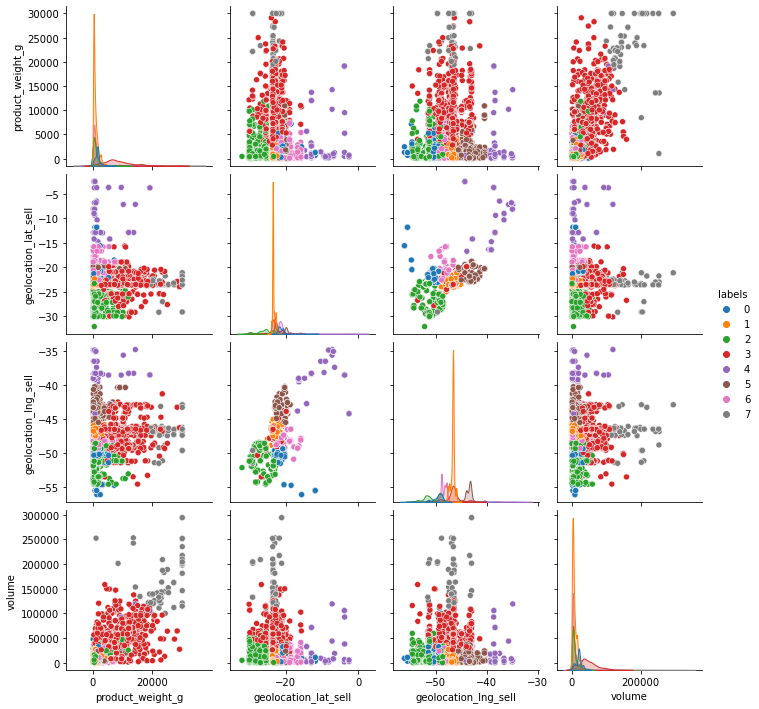

In [592]:
# scatter plot de todas las variables consideradas en la clusterización (sin estandarizar)
sns.pairplot(visualizar, hue='labels', palette="tab10")

In [640]:
# registros por label, los más nutridos: 0, 4, 2 y 3
pd.DataFrame(data.labels.value_counts()).sort_index().transpose()

0    1     2     3     4    5   6    7
labels  3519  503  1167  1165  2048  127  64  973

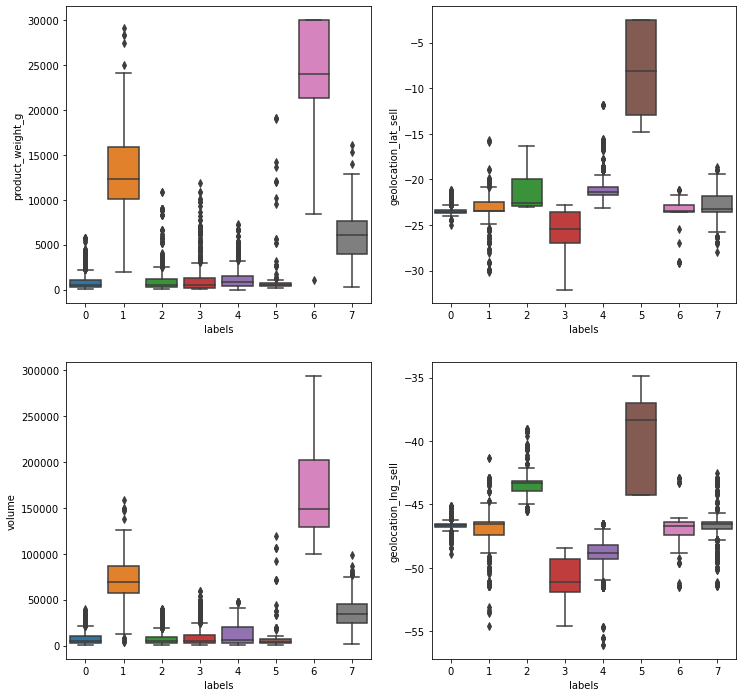

In [616]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
for i, columna in enumerate(columnas_cluster):
    sns.boxplot(x='labels', y=columna, data=visualizar, ax=ax[i%2,int(i/2)])

Se puede observar de las anteriores gráficas que los labels relativos al grupo 3 y 5 son de ciudades que están ubicadas más al oeste (longitud negativa) y al este (longitud positiva) respectivamente, así como en el caso del grupo 5 más al norte. De igual manera se puede interpretar el grupo 2. Mientras que los grupos 0, 1, 4, 6 y 7 son muy similares en su ubicación geógrafica. En particular el grupo 0, 1 y 6. 

Mientras que si se analizan las variables de volumen y peso, se encuentra que el grupo 6 es el de los productos más pesados y grandes (era de esperarse está correspondencia entre tamaño y peso), seguido del grupo 1 en el cuál se encuentran pesados con un volumen normal, seguido del 7 y los demás grupos con productos muy similares (podrían categorizarse como livianos y pequeños)

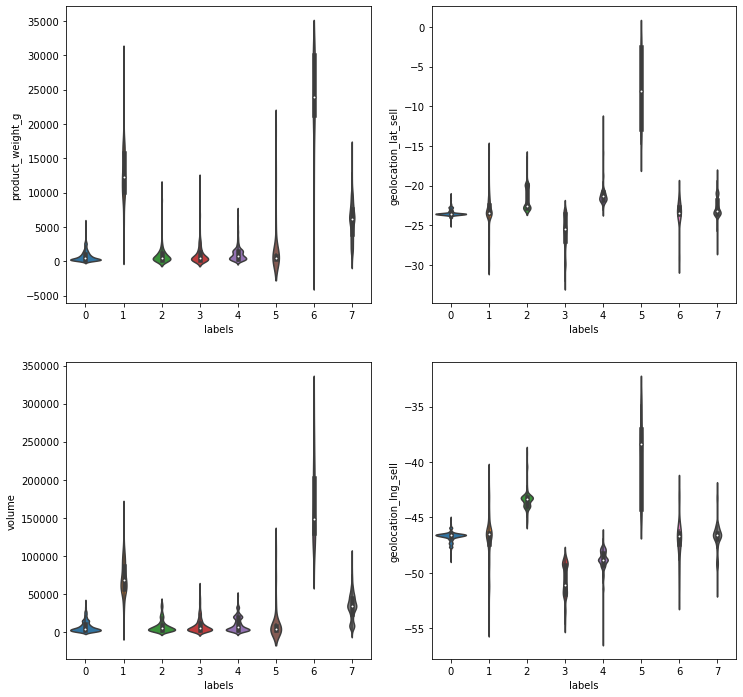

In [614]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
for i, columna in enumerate(columnas_cluster):
    sns.violinplot(x='labels', y=columna, data=visualizar, ax=ax[i%2,int(i/2)])

In [625]:
visualizar['categoria'] = df3.product_category_name
visualizar['estado'] = df3.seller_state

In [637]:
visualizar.groupby(by='labels')['estado'].apply(lambda x: x.value_counts().head(3))

labels    
0       SP    3452
        MG      67
1       SP     353
        MG      57
        PR      30
2       RJ     676
        MG     398
        ES      42
3       PR     677
        SC     295
        RS     170
4       SP    1790
        MG     122
        DF      71
5       BA      50
        MA      36
        PE      25
6       SP      46
        SC       6
        MG       6
7       SP     667
        MG     185
        PR      52
Name: estado, dtype: int64

Al hacer un conteo y escoger los 3 estados más representativos de cada label, se encuentra que lo dicho anteriormente está correctamente sustentado, mientras el 3 está dominado en gran parte por Paraná y San Carlos estados que quedan más al suroeste y el grupo 5 por los estados de Bahia y Maranhão que además quedan más al noroeste del país. Otro de los mencionados diferentes era el grupo 2 que corresponden a los estados de Rio de Janeiro y Minas Gerais, recostados al este y centrales. Pero muy diferentes del resto en su mayoría representados por São Paulo el estado tradicional para la venta y producción de artículos de toda clase.

In [639]:
visualizar.groupby(by='labels')['categoria'].apply(lambda x: x.value_counts().head(3))

labels                        
0       moveis_decoracao          306
        beleza_saude              284
        relogios_presentes        264
1       moveis_escritorio         152
        utilidades_domesticas      71
        moveis_decoracao           40
2       beleza_saude              199
        informatica_acessorios    108
        perfumaria                105
3       informatica_acessorios    208
        esporte_lazer             181
        moveis_decoracao          106
4       cama_mesa_banho           588
        ferramentas_jardim        220
        relogios_presentes        209
5       beleza_saude               42
        telefonia                  30
        informatica_acessorios     21
6       moveis_decoracao            8
        moveis_escritorio           7
        esporte_lazer               7
7       cama_mesa_banho           113
        ferramentas_jardim         87
        moveis_decoracao           81
Name: categoria, dtype: int64

De igual manera se puede ver que los grupos con mayores volumenes y pesos corresponden a categorías de productos de muebles de decoración, muebles de escritorio y artículos de deporte y pasatiempos. Seguido del label 1 que a su vez está relacionado a muebeles de escritorio, utilidades domésticas y muebles de decoración. Y seguido del label 7 donde se destacan las camas/mesas de baño, herramientas de jardinería y los muebles de decoración. En los otros labels los artículos son en su mayoría pequeños como lo son el grupo 0 con muebeles de decoración, belleza/salud, el 2 que también destaca belleza/salud y accesorios de informática.

Una vez finalizada esta clusterización queda en evidencia que a pesar de no considerarse todas las variables disponibles en el dataset se puede sacar provecho a la misma para organizar la logística y en particular tener cuidado especial con aquellos lugares donde las compras son relativas a artículos pequeños, así como de no disponer de transporte muy grande, mientras que en las ciudades que su mayor comercio se representa por artículos pesados hacer uso de esto para destinar carros de mayor capacidad y centros de acopio con las medidas necesarias.

## Producción

Para mostrar los modelos en producción se pedirá que se ingresen de manera manual los valores usados para la predicción. En el siguiente orden:
- 'product_weight_g': peso en gramos
- 'volume': volumen del producto en centímetros cúbicos
- 'price': precio en reales
- 'geolocation_lng_sell': longitud del vendedor 
- 'geolocation_lat_sell': latitud del vendedor
- 'geolocation_lng_cust': longitud comprador (ciudades principales de Rio de Janeiro)
- 'geolocation_lat_cust': latitud comprador
- 'year': año (valores entre 2016 y 2018)
- 'month': mes
- 'day': día de la semana (0 lunes - 6 domingo)

In [683]:
import gradio as gr

In [715]:
#cargando modelos guardados
rf_clas = joblib.load("./rf_clasificacion.joblib")
rf_reg = joblib.load("./rf_regresion.joblib")
scal = joblib.load("./reg_scaler.joblib")

# función que procesa información y devuelve data frame con predicciones
# tener en cuenta: año entre 2016 y 2018
# día es día de la semana 0 lunes - 6 domingo
# volumen en centimetros cúbicos
def interfaz(compra):
    aux = compra.copy()
    aux['distance'] = aux.apply(lambda x: haversine(x['geolocation_lng_sell'], x['geolocation_lat_sell'], x['geolocation_lng_cust'], 
                              x['geolocation_lat_cust']), axis=1)
    aux2 = pd.DataFrame([rf_reg.predict(scal.transform(aux)), rf_clas.predict(aux)], columns=aux.index, index=['flete', 'tarde']).transpose()
    aux2['tarde'] = aux2.apply(lambda x: 'si' if x['tarde'] == 1 else 'no', axis = 1)
    return aux2

iface = gr.Interface(interfaz, 
    gr.inputs.Dataframe(
        headers=["product_weight_g", "volume", "price", "geolocation_lng_sell", "geolocation_lat_sell","geolocation_lng_cust", "geolocation_lat_cust", "month", "day", "year"],
        default=[[2950.0, 8100.0, 129.9,-46.82420582829658, -23.002859858736702,-43.18629265033459, -22.91259168660638, 2.0, 2.0, 2018.0]]
    ),
    [
        "dataframe"
    ],
    description="Entra la información para determinar el valor del flete y si va a llegar atrasada."
)
iface.launch()

Running on local URL:  http://127.0.0.1:7864/

To create a public link, set `share=True` in `launch()`.


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7864/', None)